# Chapter 10
## Building Univariate Time Series Models Using Statistical Methods


# ---START: Technical Requirements---


In [194]:
#!pip install pandas statsmodels matplotlib scikit-learn

In [196]:
%config Completer.use_jedi = False

In [198]:
import matplotlib 
import scipy 
import sklearn
import statsmodels
import numpy
import pandas

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pandas.__version__}   
numpy -> {numpy.__version__}
scipy -> {scipy.__version__}
statsmodels -> {statsmodels.__version__}
sklearn -> {sklearn.__version__}
''')


Matplotlib -> 3.10.0
pandas -> 2.2.3   
numpy -> 1.26.4
scipy -> 1.14.1
statsmodels -> 0.14.4
sklearn -> 1.5.2



In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import warnings

# Time series analysis tools
from statsmodels.tsa.api import adfuller, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Model evaluation metrics
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape

# Utility functions
from itertools import product
from pathlib import Path


# warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]  
plt.style.use('grayscale')

In [202]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
#plt.rcParams['figure.dpi'] = 100          ## use 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=14)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [204]:
# Define file paths for the datasets
life_file = Path('../../datasets/Ch10/life_expectancy_birth.csv')
milk_file = Path('../../datasets/Ch10/milk_production.csv')

life = pd.read_csv(life_file, 
                   index_col='year',
                   parse_dates=True,
                   skipfooter=1)

milk = pd.read_csv(milk_file, 
                   index_col='month', 
                   parse_dates=True)

/var/folders/48/j6k669vx63qd_68k2_502cl40000gn/T/ipykernel_1321/2280038795.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  life = pd.read_csv(life_file,


In [206]:
life.shape

(59, 1)

In [208]:
milk.shape

(168, 1)

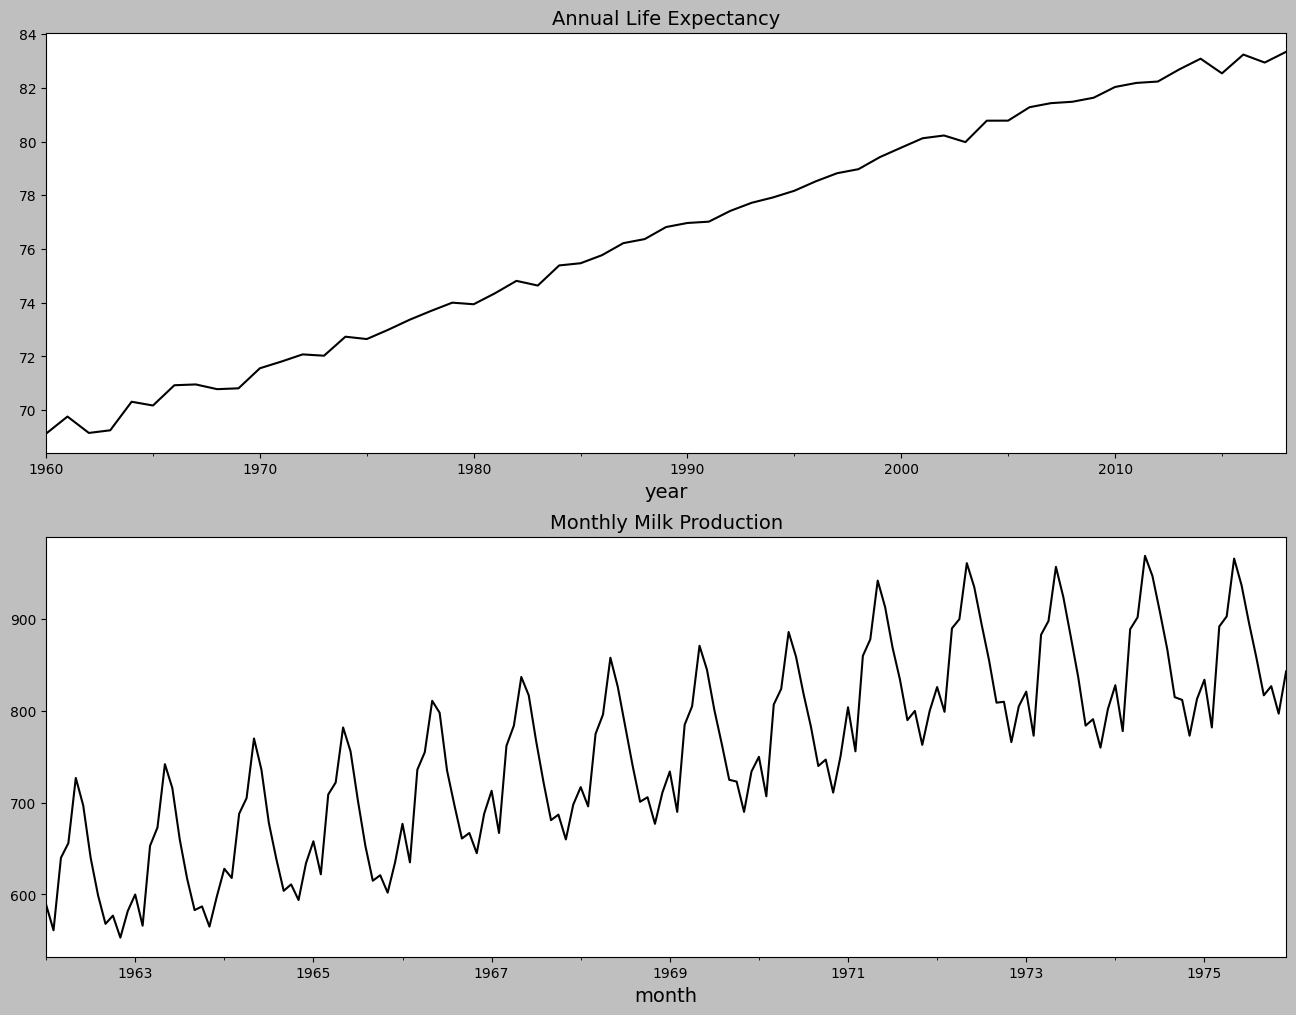

In [210]:
# Create subplots for visual comparison of both time series
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
life.plot(title='Annual Life Expectancy', 
                        legend=False, ax=ax[0])
milk.plot(title='Monthly Milk Production', 
                        legend=False, ax=ax[1]);

# plt.savefig('images/fig_10.1.png', bbox_inches='tight', dpi=300)

In [211]:
def split_data(data, test_split):
    """
    Split time series data into train and test sets while preserving temporal order.
    
    Parameters:
    data : pandas.DataFrame or Series
        Time series data to split
    test_split : float
        Proportion of data to use for testing (0 to 1)
        
    Returns:
    train, test : tuple of pandas.DataFrame or Series
        Training and test sets maintaining temporal order
    """
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [214]:
test_split = 0.15
milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)

train: 143 , test: 25
train: 50 , test: 9


### 1. check_stationarity() function

In [217]:
def check_stationarity(df):
    """
    Test if a time series is stationary using the Augmented Dickey-Fuller test.
    
    Parameters:
    df : pandas Series/DataFrame
        Time series data
        
    Returns:
    tuple : (status, p_value)
        status: 'Stationary' or 'Non-Stationary'
        p_value: ADF test p-value
    """
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [219]:
# Old Function
# def get_best_model(score, c='AIC'):
#     initial_score = score[1][c]
#     best_model = 0
#     for k,v in score.items():
#         if v[c] < initial_score:
#             initial_score = v[c]
#             best_model = k
#     print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
#     return score[best_model]['model']

In [221]:
# def get_best_model(score, criterion='AIC'):
#     sorted_scores = sorted(score.items(), 
#                            key=lambda item: item[1][criterion])

#     best_model = sorted_scores[0]['model']

#     return best_model

### 2. get_top_models_df() function

In [224]:
# Updated new function
def get_top_models_df(scores, criterion='AIC', top_n=5):
    """
    Rank time series models based on their performance metrics.
    
    Parameters:
    scores : dict
        Dictionary of model results and their metrics
    criterion : str, default='AIC'
        Metric for ranking (AIC, RMSE, MAPE, etc.)
    top_n : int, default=5
        Number of top models to return
        
    Returns:
    DataFrame with top performing models sorted by criterion
    """
    sorted_scores = sorted(scores.items(), 
                           key=lambda item: item[1][criterion])
    
    top_models = sorted_scores[:top_n]

    data = [v for k, v in top_models]
    df = pd.DataFrame(data)
    
    df['model_id'] = [k for k, v in top_models]
    df.set_index('model_id', inplace=True)

    return df

### 3. plot_forecast() function

In [227]:
def plot_forecast(model, start, train, test):
    """
    Visualize model forecasts against actual values.
    
    Parameters:
    model : fitted time series model
    start : datetime-like
        Plot starting point
    train : Series/DataFrame
        Training data
    test : Series/DataFrame
        Test data
    
    Displays a plot comparing training data, test data, and forecasts
    """

    if not hasattr(model, 'forecast'):
        raise AttributeError("The provided model does not have a 'forecast' method.")

        
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    # plt.show()
    return ax

### 4. combinator() function

In [230]:
def combinator(items, r=1):
    """
    Generate parameter combinations for grid search.
    
    Parameters:
    items : list of lists
        Lists of parameter values to combine
        
    Returns:
    list of tuples containing all possible parameter combinations
    """
    combo = [i for i in product(*items, repeat=r)]
    return combo

# Recipe 1. Plotting ACF and PACF

<Axes: xlabel='year'>

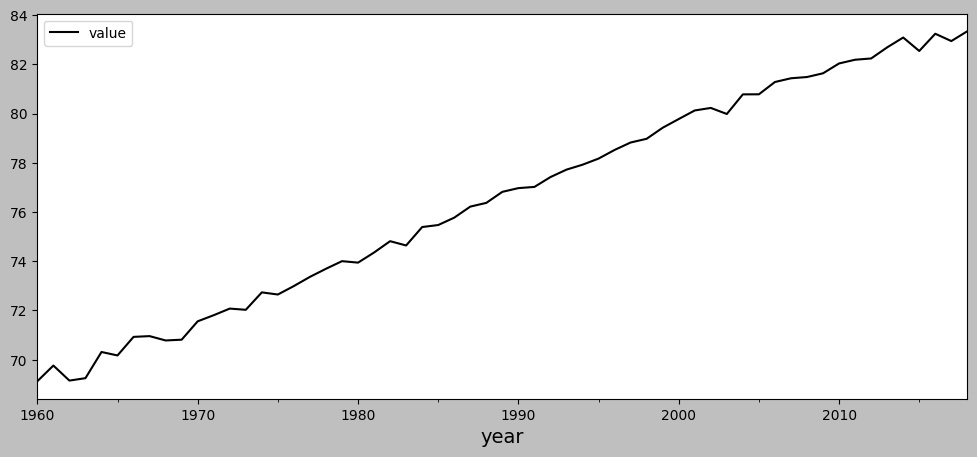

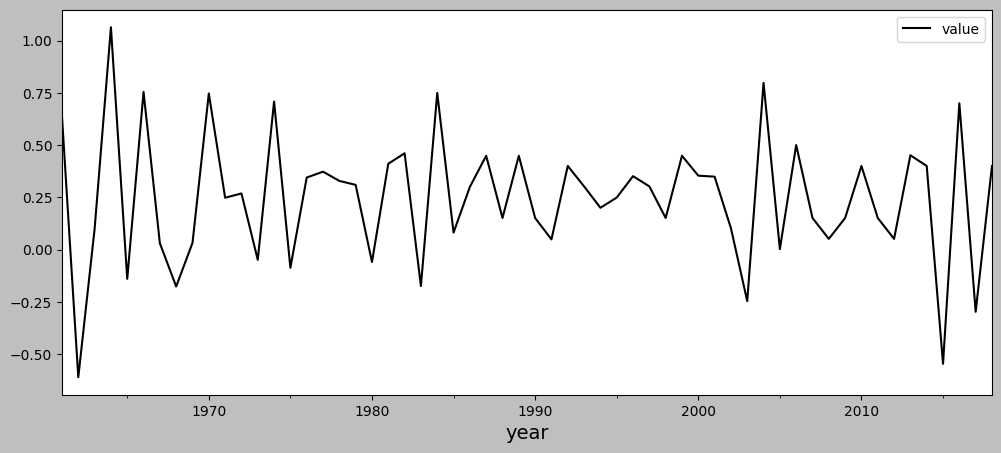

In [233]:
# plt.rcParams["figure.figsize"] = [16, 4]
life.plot()
life_diff = life.diff().dropna()
life_diff.plot()

In [61]:
check_stationarity(life)

'Non-Stationary	 p-value:0.6420882853800078 	 lags:2


('Non-Stationary', 0.6420882853800078)

In [63]:
check_stationarity(life_diff)

'Stationary	 p-value:1.5562189676003415e-14 	 lags:1


('Stationary', 1.5562189676003415e-14)

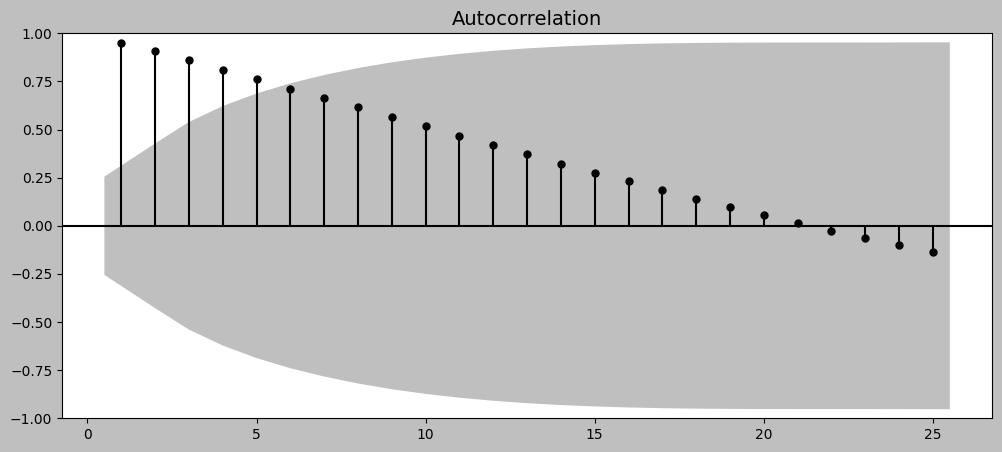

In [151]:
plot_acf(life, lags=25,zero=False);

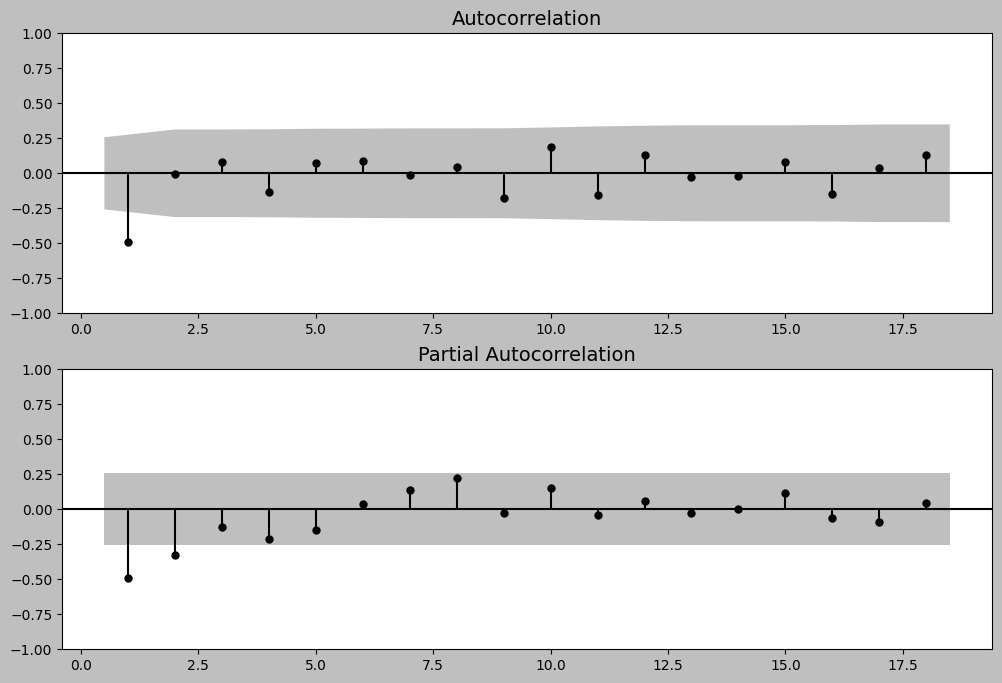

In [153]:
# Calculate first differences and remove any NA values
fig, ax = plt.subplots(2,1, figsize=(12,8))

# Create subplots for both ACF and PACF
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1]);
#plt.savefig('images/fig_10.2.png', bbox_inches='tight', dpi=300)

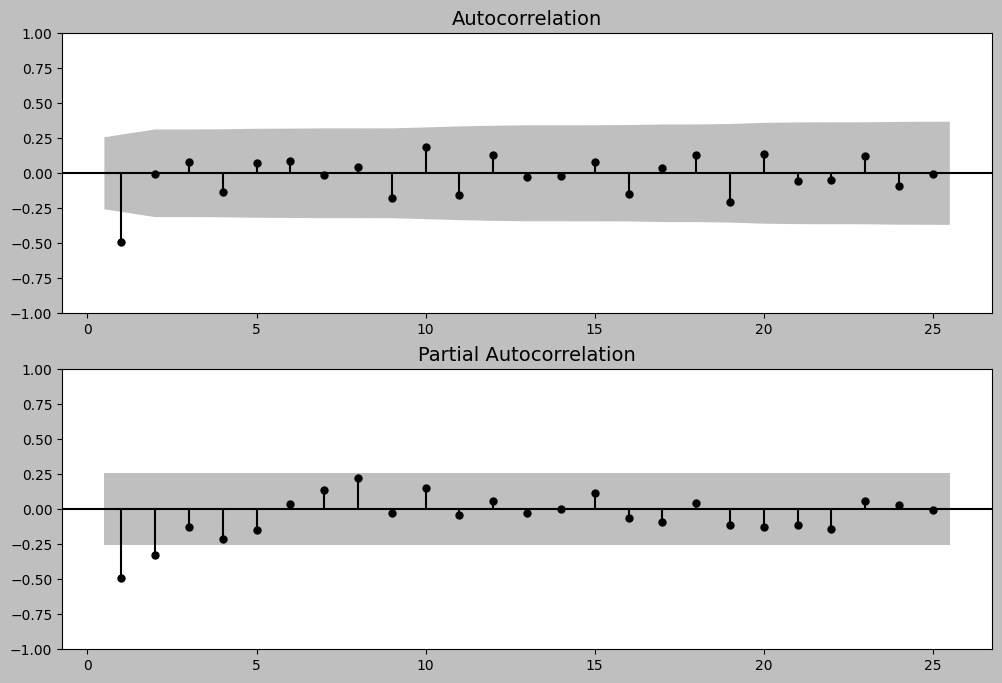

In [71]:
# increase number of lags
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, lags=25, zero=False, ax=ax[0])
plot_pacf(life_diff, lags=25,  zero=False, ax=ax[1]);

<Axes: xlabel='month'>

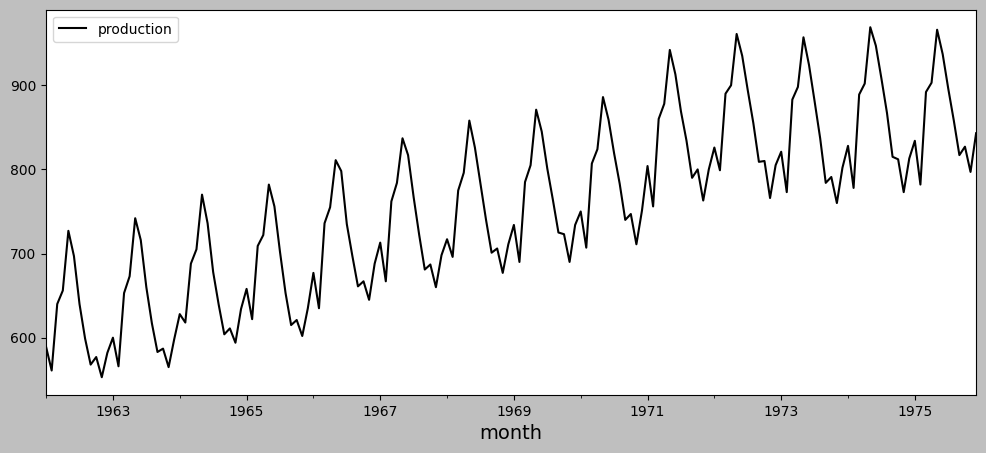

In [73]:
milk.plot()

<Axes: xlabel='month'>

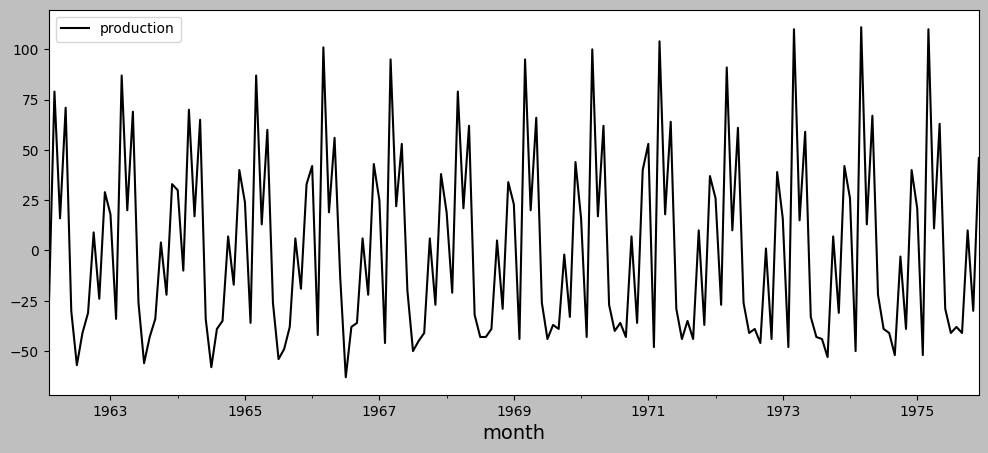

In [93]:
milk.diff().dropna().plot()

<Axes: xlabel='month'>

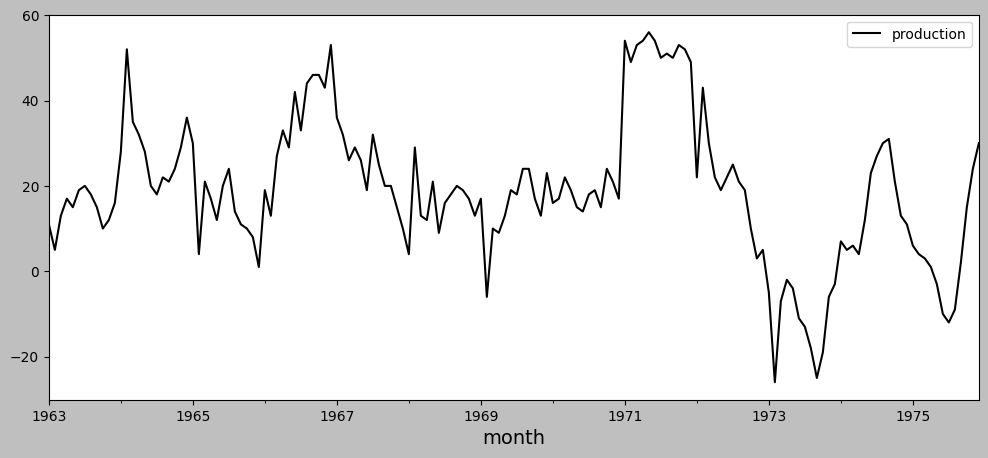

In [95]:
milk.diff(12).dropna().plot()

<Axes: xlabel='month'>

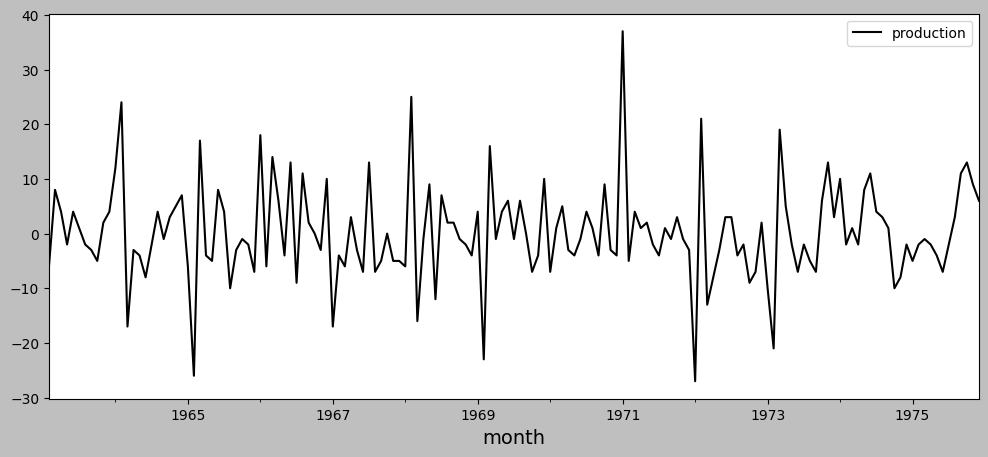

In [101]:
milk.diff(12).diff().dropna().plot()

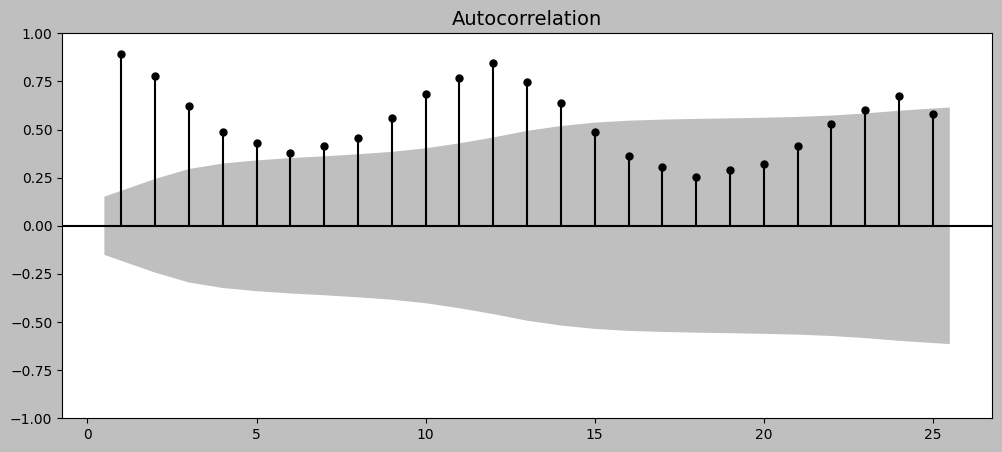

In [169]:
plot_acf(milk, lags=25,zero=False, alpha=0.05);

In [107]:
milk_diff_12 = milk.diff(12).dropna()

In [109]:
check_stationarity(milk_diff_12)

'Non-Stationary	 p-value:0.16079880527711332 	 lags:12


('Non-Stationary', 0.16079880527711332)

In [89]:
milk_diff_12_1 = milk.diff(12).diff(1).dropna()
check_stationarity(milk_diff_12_1)

'Stationary	 p-value:1.865423431878889e-05 	 lags:11


('Stationary', 1.865423431878889e-05)

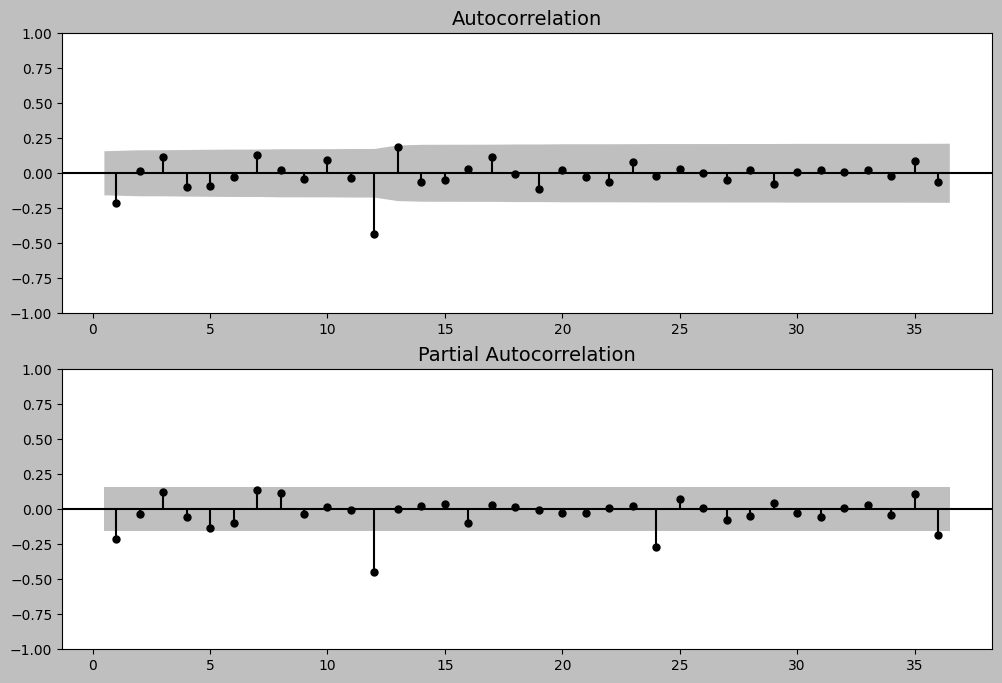

In [159]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36)
# plt.savefig('images/fig_10.3.png', bbox_inches='tight', dpi=300)
plt.show()

## There is more

In [190]:
%config Completer.use_jedi = False


In [204]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(milk, order=(0,1,1),
                seasonal_order=(0,1,1, 12),
               freq='MS').fit(disp=False)

/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


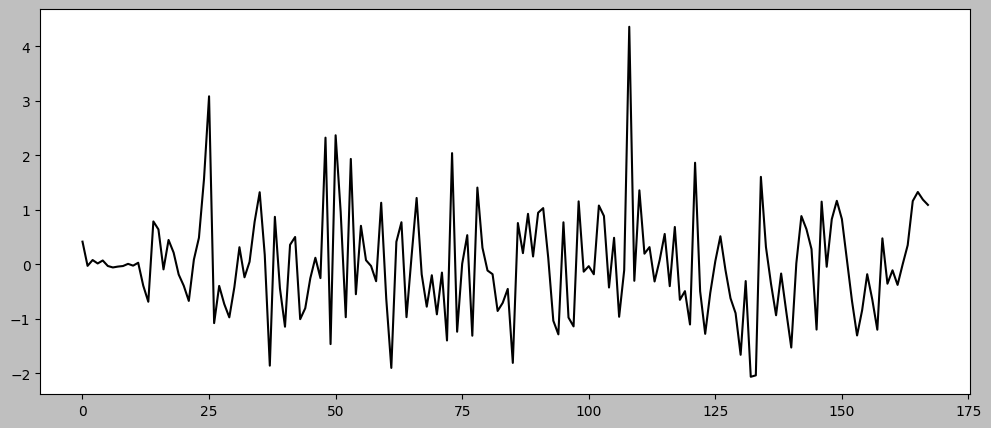

In [206]:
plt.plot(model.filter_results.standardized_forecasts_error[0]);

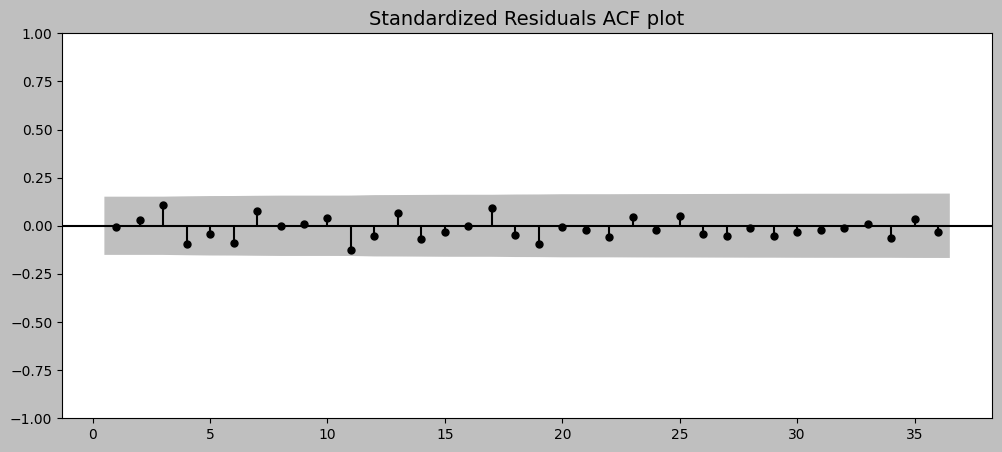

In [216]:
standardized_resid = model.filter_results.standardized_forecasts_error[0]
plot_acf(standardized_resid, 
         zero=False, 
         lags=36, 
         title='Standardized Residuals ACF plot');

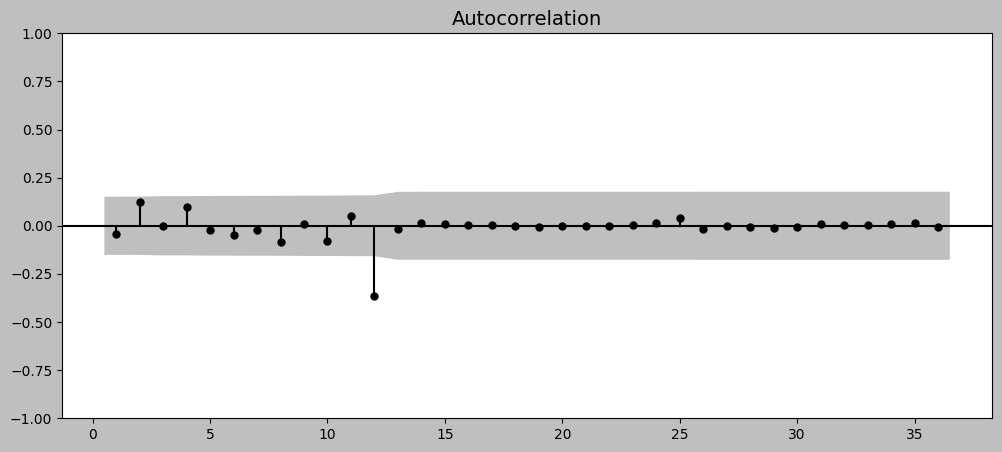

In [208]:
plot_acf(model.resid, zero=False, lags=36);

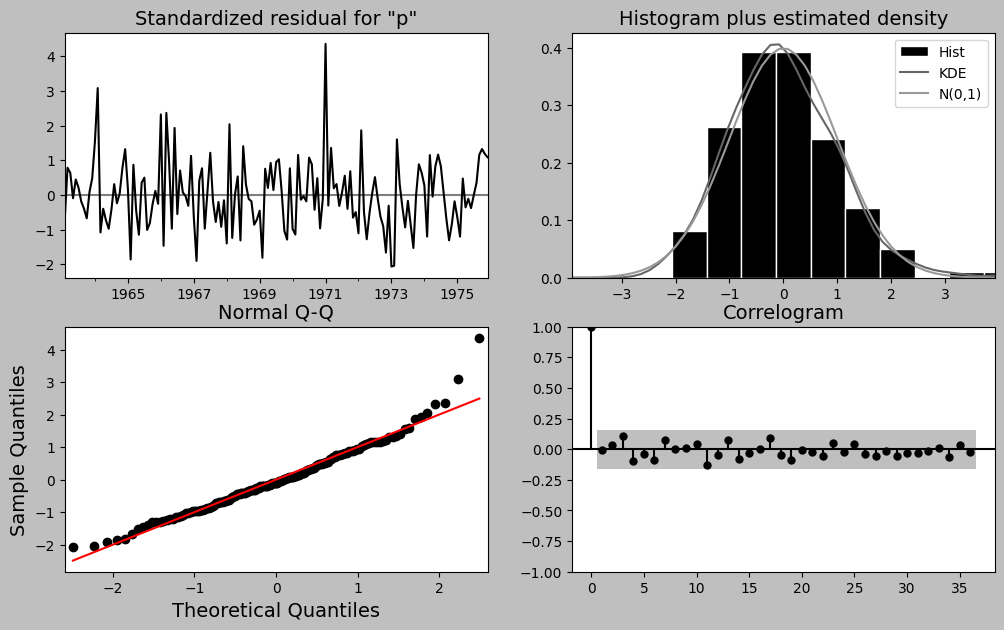

In [212]:
model.plot_diagnostics(figsize=(12,7), lags=36);

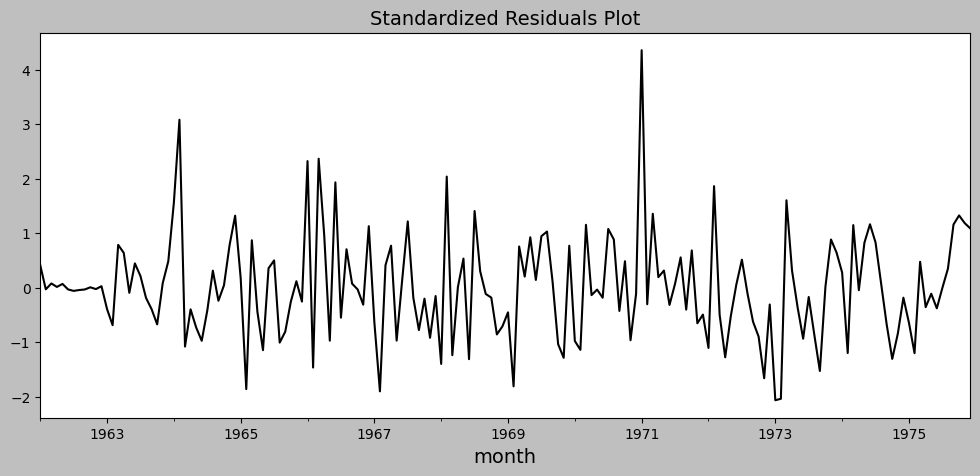

In [68]:
pd.DataFrame(model.standardized_forecasts_error.ravel(), 
             index=milk.index).plot(title='Standardized Residuals Plot', 
                                    legend=False);

# Recipe 2. Forecasting Univariate Time Series Data with Exponential Smoothing

In [40]:
from statsmodels.tsa.api import ExponentialSmoothing

In [42]:
trend = ['add', 'mul']
damped = [True, False]
life_ex_comb = combinator([trend, damped])
print(life_ex_comb)

[('add', True), ('add', False), ('mul', True), ('mul', False)]


In [44]:
train = life_train.values.ravel()
y = life_test.values.ravel()
score = {}
for i, (t, dp) in enumerate(life_ex_comb):
    exp = ExponentialSmoothing(train, 
                     trend=t, 
                     damped_trend=dp,
                     seasonal=None)
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast(len(y))
    score[i] = {'trend':t, 
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc':model.aicc, 
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

In [46]:
model_eval = get_top_models_df(score)
model_eval

,trend,damped,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,,
1,add,False,-137.030602,-129.382510,-135.077113,0.067730,0.561346,0.005567,<statsmodels.tsa.holtwinters.results.HoltWinte...
3,mul,False,-136.344215,-128.696123,-134.390727,0.070529,0.584593,0.005835,<statsmodels.tsa.holtwinters.results.HoltWinte...
2,mul,True,-134.829825,-125.269710,-132.163158,0.064576,0.535155,0.005268,<statsmodels.tsa.holtwinters.results.HoltWinte...
0,add,True,-133.771858,-124.211743,-131.105192,0.051100,0.423411,0.003975,<statsmodels.tsa.holtwinters.results.HoltWinte...


In [48]:
get_top_models_df(score, criterion='BIC', top_n=3)

,trend,damped,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,,
1,add,False,-137.030602,-129.382510,-135.077113,0.067730,0.561346,0.005567,<statsmodels.tsa.holtwinters.results.HoltWinte...
3,mul,False,-136.344215,-128.696123,-134.390727,0.070529,0.584593,0.005835,<statsmodels.tsa.holtwinters.results.HoltWinte...
2,mul,True,-134.829825,-125.269710,-132.163158,0.064576,0.535155,0.005268,<statsmodels.tsa.holtwinters.results.HoltWinte...


In [50]:
model_eval.iloc[:, 0:-1]

,trend,damped,AIC,BIC,AICc,RMSPE,RMSE,MAPE
model_id,,,,,,,,
1,add,False,-137.030602,-129.382510,-135.077113,0.067730,0.561346,0.005567
3,mul,False,-136.344215,-128.696123,-134.390727,0.070529,0.584593,0.005835
2,mul,True,-134.829825,-125.269710,-132.163158,0.064576,0.535155,0.005268
0,add,True,-133.771858,-124.211743,-131.105192,0.051100,0.423411,0.003975


In [52]:
top_model = model_eval.iloc[0,-1]
top_model.summary()

Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Sun, 05 Jan 2025"
Box-Cox:,False,Time:,12:51:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621957,alpha,True
smoothing_trend,0.1621957,beta,True


In [54]:
top_model.params_formatted

,name,param,optimized
smoothing_level,alpha,0.162196,True
smoothing_trend,beta,0.162196,True
initial_level,l.0,68.748482,True
initial_trend,b.0,0.242227,True


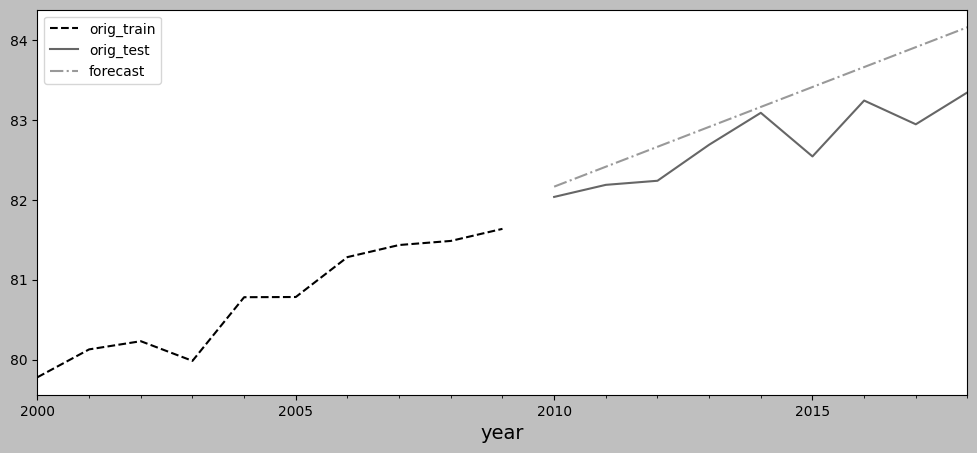

In [56]:
plot_forecast(top_model, '2000', life_train, life_test);
#plt.savefig('images/fig_10.6.png', bbox_inches='tight', dpi=300)

In [58]:
#plt.savefig('images/fig_10.6.png', bbox_inches='tight', dpi=300)

In [60]:
trend , damped= ['add', 'mul'], [True, False] 
seasonal, periods = ['add' , 'mul'], [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal, periods])

In [62]:
len(milk_exp_comb)

24

In [64]:
train = milk_train.values.ravel()
y = milk_test.values.ravel()
milk_model_scores = {}
for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    exp = ExponentialSmoothing(train, 
                        trend=t, 
                        damped_trend=dp,
                        seasonal=s,
                        seasonal_periods=sp)
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast(len(y))
    score[i] = {'trend':t,
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc': model.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [65]:
model_eval = get_top_models_df(score, 'AIC', top_n=5)
model_eval.iloc[:, 0:-1]

,trend,damped,AIC,BIC,AICc,RMSPE,RMSE,MAPE
model_id,,,,,,,,
8,add,False,593.713879,641.119393,599.230008,0.148834,12.771206,0.011727
20,mul,False,594.626210,642.031724,600.142339,0.172484,14.805816,0.014030
2,add,True,595.561428,645.929786,601.740290,0.130392,11.088734,0.010354
11,add,False,614.894828,662.300342,620.410957,0.220577,19.858622,0.017100
23,mul,False,615.432505,662.838019,620.948634,0.246482,22.139824,0.019655


In [66]:
top_model = model_eval.iloc[0,-1]
top_model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Sun, 05 Jan 2025"
Box-Cox:,False,Time:,12:51:07
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859072,alpha,True
smoothing_trend,0.000000,beta,True


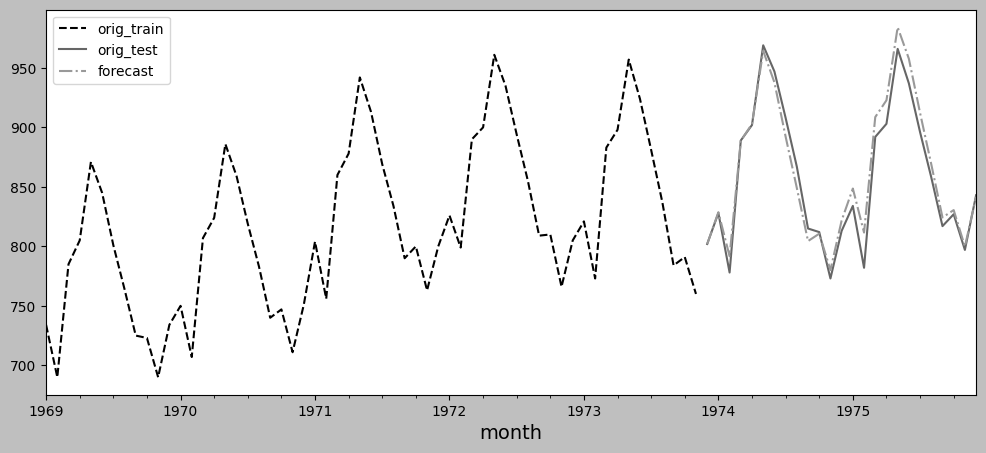

In [67]:
plot_forecast(top_model, '1969', milk_train, milk_test);
# plt.savefig('images/fig_10.8.png', bbox_inches='tight', dpi=300)

## There is more

In [73]:
#!pip install darts

In [75]:
import darts
darts.__version__

'0.32.0'

In [77]:
from darts.models import ExponentialSmoothing, StatsForecastAutoETS
from darts import TimeSeries

/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [78]:
ts = TimeSeries.from_dataframe(milk.reset_index(), 
                               time_col='month', 
                               value_cols='production', 
                               freq='MS')

In [81]:
type(ts)

darts.timeseries.TimeSeries

### Darts ExponentialSmoothing

In [84]:
# exponential smoothing
model = ExponentialSmoothing(seasonal_periods=12)

train, test = split_data(ts, 0.15)

train: 143 , test: 25


In [86]:
model

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12, random_state=0, kwargs=None)

In [88]:
model.fit(train)
forecast = model.predict(len(test), num_samples=100)

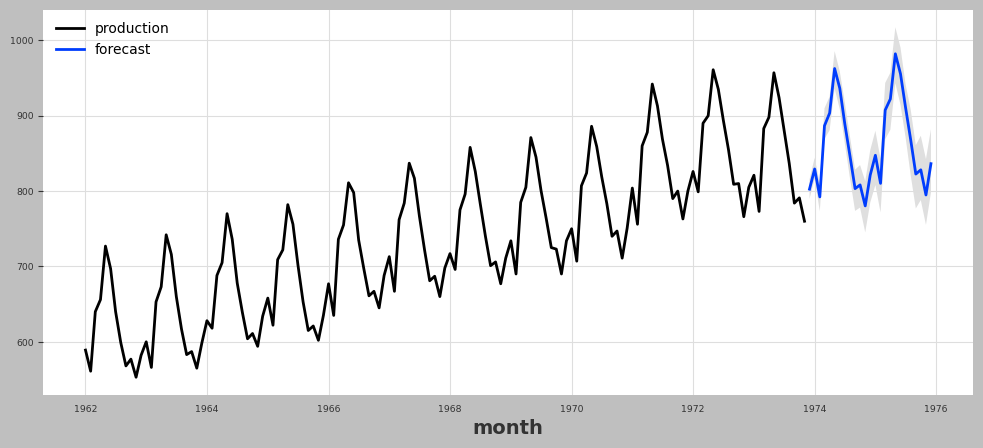

In [90]:
train.plot()
forecast.plot(label='forecast', low_quantile=0.05, high_quantile=0.95, default_formatting=False);
# plt.savefig('images/fig_10.9.png', bbox_inches='tight', dpi=300)

In [92]:
#exponential smoothing
model.model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Sun, 05 Jan 2025"
Box-Cox:,False,Time:,12:52:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859072,alpha,True
smoothing_trend,0.000000,beta,True


### Darts StatsForecastAutoETS

In [95]:
# StatsForecast AutoETS
model_ets = StatsForecastAutoETS(season_length=12)
model_ets.fit(train)

StatsForecastAutoETS(add_encoders=None, season_length=12)

In [97]:
ets_forecast = model_ets.predict(len(test), num_samples=100)

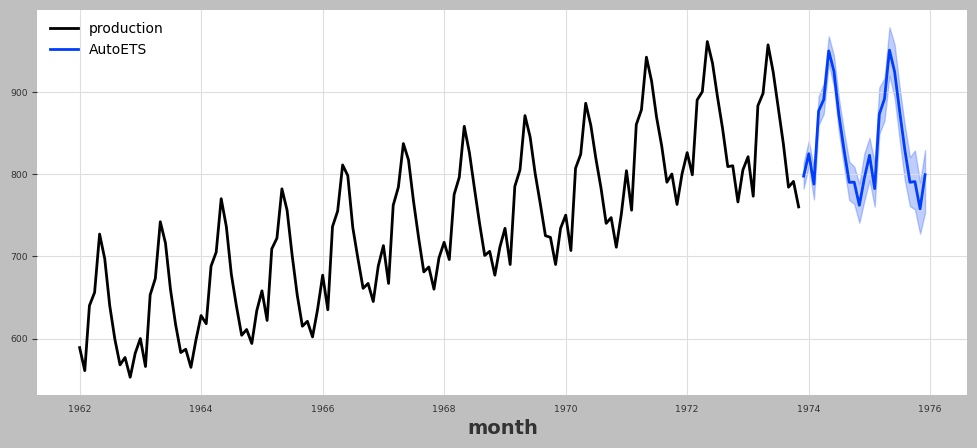

In [99]:
train.plot()
ets_forecast.plot(label='AutoETS');

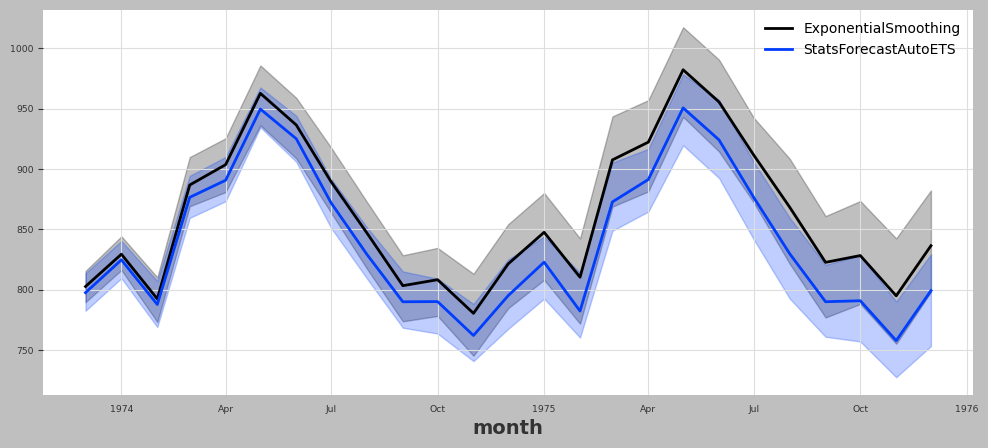

In [105]:
forecast.plot(label='ExponentialSmoothing')
ets_forecast.plot(label='StatsForecastAutoETS');

In [103]:
#modelets.model.model_

# Recipe 3. Forecasting Univariate Time Series Data with Non-Seasonal ARIMA

In [235]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
plt.rcParams["figure.figsize"] = [14, 4]  

In [237]:
life.index

DatetimeIndex(['1960-01-01', '1961-01-01', '1962-01-01', '1963-01-01',
               '1964-01-01', '1965-01-01', '1966-01-01', '1967-01-01',
               '1968-01-01', '1969-01-01', '1970-01-01', '1971-01-01',
               '1972-01-01', '1973-01-01', '1974-01-01', '1975-01-01',
               '1976-01-01', '1977-01-01', '1978-01-01', '1979-01-01',
               '1980-01-01', '1981-01-01', '1982-01-01', '1983-01-01',
               '1984-01-01', '1985-01-01', '1986-01-01', '1987-01-01',
               '1988-01-01', '1989-01-01', '1990-01-01', '1991-01-01',
               '1992-01-01', '1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
      

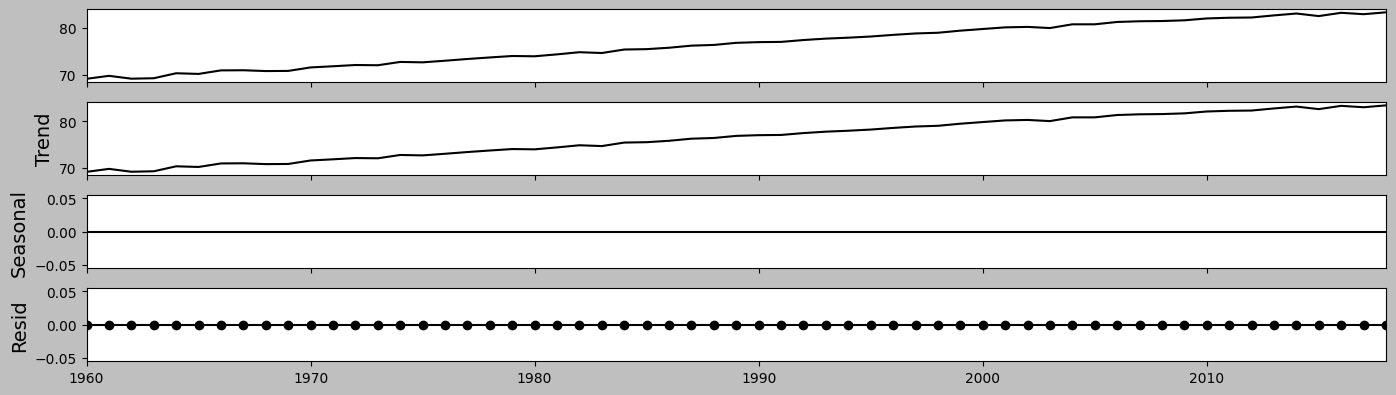

In [239]:
decomposed = seasonal_decompose(life)
decomposed.plot();
#plt.savefig('images/fig_10.10.png', bbox_inches='tight', dpi=300)

In [135]:
# plt.rcParams["figure.figsize"] = [14, 6]  
# decomposed = seasonal_decompose(milk, period=12)
# decomposed.plot();

In [137]:
from pandas.plotting import autocorrelation_plot

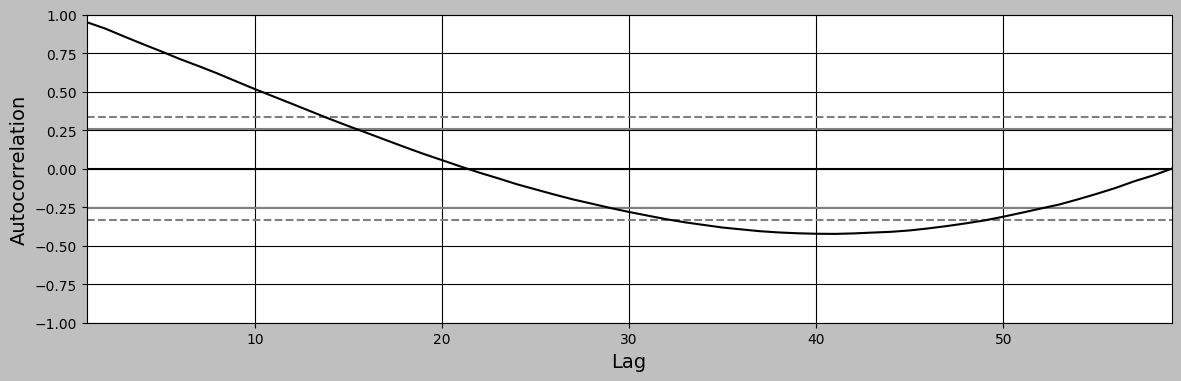

In [139]:
autocorrelation_plot(life);

In [141]:
check_stationarity(life)

'Non-Stationary	 p-value:0.6420882853800078 	 lags:2


('Non-Stationary', 0.6420882853800078)

In [143]:
life_df1 = life.diff().dropna()
check_stationarity(life_df1)

'Stationary	 p-value:1.5562189676003415e-14 	 lags:1


('Stationary', 1.5562189676003415e-14)

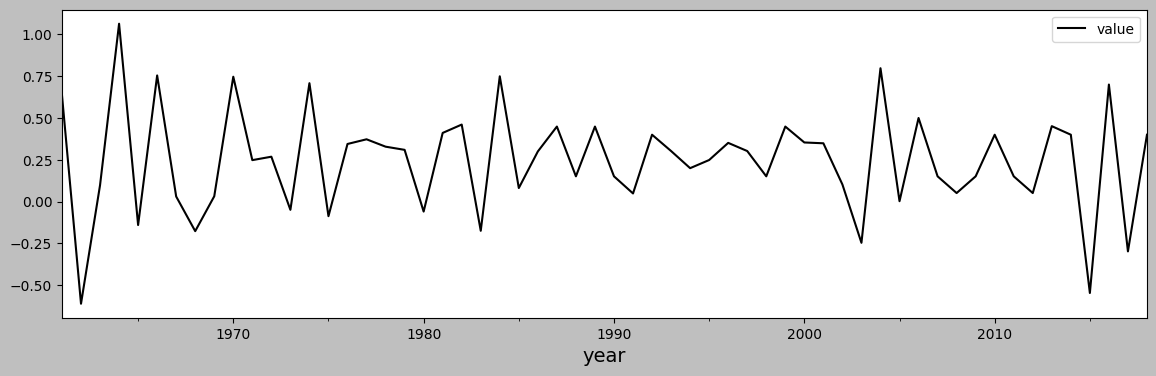

In [241]:
life_df1.plot();
#plt.savefig('images/fig_10.11.png', bbox_inches='tight', dpi=300)

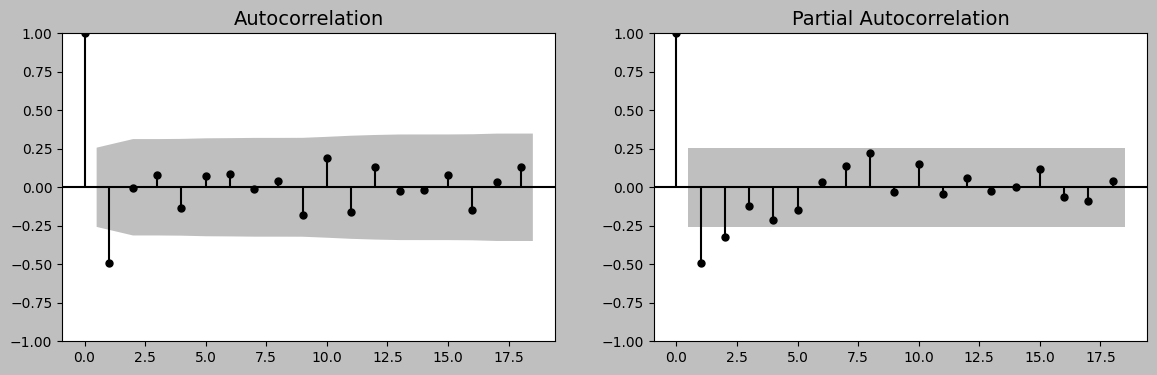

In [243]:
fig, ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1]);
#plt.savefig('images/fig_10.12.png', bbox_inches='tight', dpi=300)

In [245]:
(acorr_ljungbox(life_df1, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()
# there is autocorrelation as we would expect 

24

In [251]:
model = ARIMA(life_train, order=(0,1,1))
results = model.fit()
results.summary()

/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -24.161
Date:                Fri, 10 Jan 2025   AIC                             52.321
Time:                        20:48:49   BIC                             56.105
Sample:                    01-01-1960   HQIC                            53.757
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0827      0.200      0.413      0.680      -0.310       0.475
sigma2         0.1569      0.032      4.918      0.000       0.094       0.219
===================================================================================
Ljung-Box (L1) (Q):                  12.54   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               0.43   Skew:                             0.07
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [153]:
# Extract standardized residuals
standardized_residuals = results.filter_results.standardized_forecasts_error[0]

# Perform Ljung-Box test on standardized residuals
ljungbox_results = acorr_ljungbox(standardized_residuals, lags=25, return_df=True)
print(ljungbox_results)

# Count significant p-values (<0.05)
significant_lags = (ljungbox_results['lb_pvalue'] < 0.05).sum()
print(f"Number of significant lags: {significant_lags}")

      lb_stat  lb_pvalue
1   13.433249   0.000247
2   13.433339   0.001211
3   13.945365   0.002980
4   16.387338   0.002541
5   17.461698   0.003703
6   17.540975   0.007488
7   17.547329   0.014188
8   18.083433   0.020610
9   21.436069   0.010849
10  22.965142   0.010876
11  23.057245   0.017349
12  23.059045   0.027229
13  23.474136   0.036326
14  24.472604   0.040145
15  25.848427   0.039646
16  27.477992   0.036466
17  27.478249   0.051416
18  30.761317   0.030671
19  36.785699   0.008439
20  40.353317   0.004506
21  41.309009   0.005134
22  41.570750   0.007042
23  45.654651   0.003301
24  49.217984   0.001778
25  49.428292   0.002505
Number of significant lags: 24


In [155]:
(acorr_ljungbox(standardized_residuals, 
                lags=25,
                return_df=True))['lb_pvalue']

1     0.000247
2     0.001211
3     0.002980
4     0.002541
5     0.003703
6     0.007488
7     0.014188
8     0.020610
9     0.010849
10    0.010876
11    0.017349
12    0.027229
13    0.036326
14    0.040145
15    0.039646
16    0.036466
17    0.051416
18    0.030671
19    0.008439
20    0.004506
21    0.005134
22    0.007042
23    0.003301
24    0.001778
25    0.002505
Name: lb_pvalue, dtype: float64

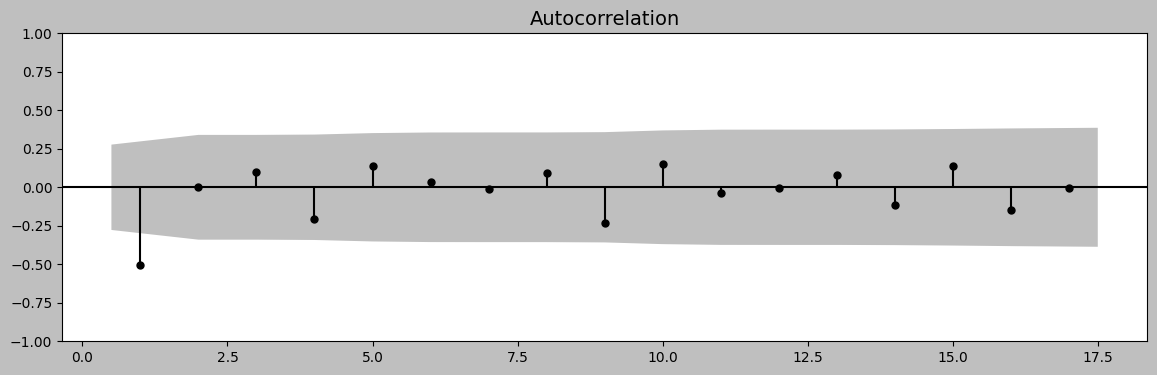

In [253]:
plot_acf(standardized_residuals, zero=False);

In [255]:
# from statsmodels.graphics.gofplots import qqplot

# pd.Series(results.resid).plot(kind='kde');plt.show()
# qqplot(results.resid, line='s'); plt.show()

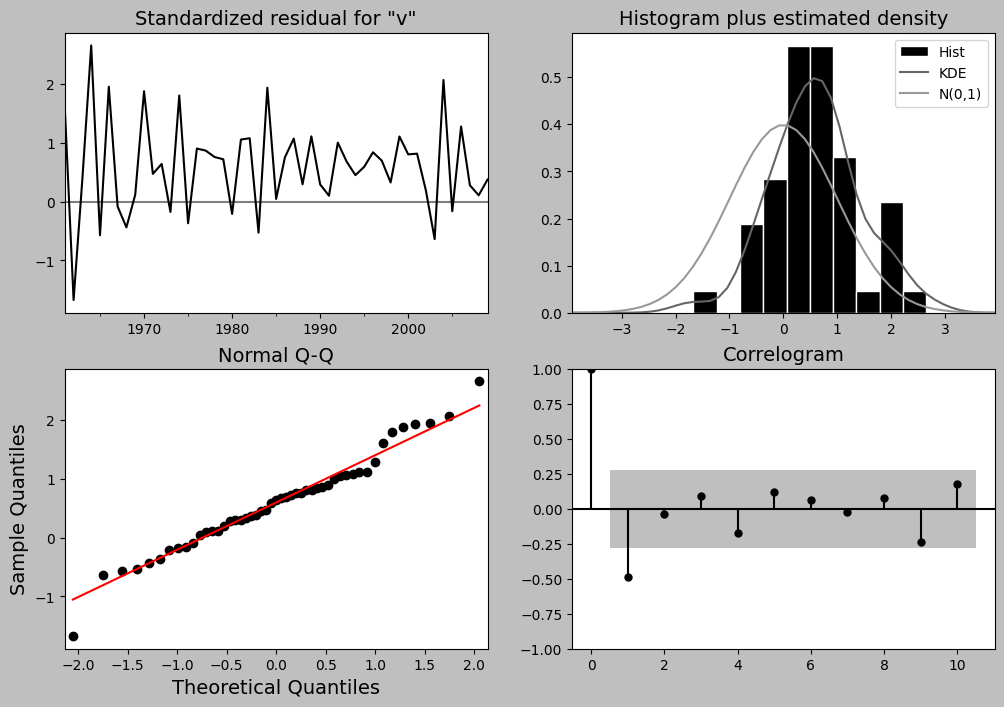

In [271]:
results.plot_diagnostics(figsize=(12,8));
#plt.savefig('images/fig_10.15.png', bbox_inches='tight', dpi=300)

In [163]:
(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

In [165]:
from scipy.stats import shapiro
shapiro(standardized_residuals)[1] < 0.05

False

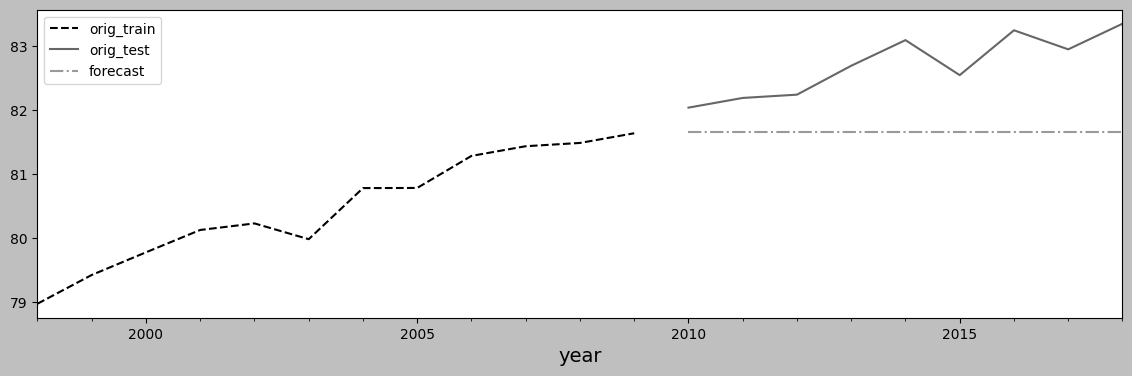

In [167]:
plot_forecast(results, '1998', life_train, life_test);

## There is more

In [275]:
# Create lists [0,1,2] for p, d, and q
pv, dv, qv = [list(range(3))]*3
# Generate all possible combinations
vals = combinator([pv, dv, qv ])

# Initialize a dictionary to store results
score = {}

# Train multiple ARIMA models
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_train.values.ravel() 
    y_hat = res.forecast(steps=len(y))
 # Store multiple performance metrics for comparison
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'RMSPE': rmspe(y, y_hat),
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}


/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No freque

In [277]:
top_5_models = get_top_models_df(score, 'AIC')
top_5_models

,order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
model_id,,,,,,,,
8,"(0, 2, 2)",7.699045,1.654407,13.312648,8.244500,12.370887,0.164672,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
14,"(1, 1, 2)",9.533198,1.638464,17.100480,10.442289,12.240133,0.162934,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
17,"(1, 2, 2)",9.676092,1.653341,17.160896,10.606325,12.362413,0.164560,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
23,"(2, 1, 2)",11.512779,1.636882,20.971880,12.908127,12.227453,0.162765,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
26,"(2, 2, 2)",13.831020,1.759270,23.187025,15.259592,13.209193,0.175637,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [279]:
best_m = top_5_models.iloc[0,-1]
best_m

In [281]:
#  you can always change the top_n and criterion and shown
get_top_models_df(score, 'MAPE', top_n=27)

,order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
model_id,,,,,,,,
0,"(0, 0, 0)",280.675284,0.513646,284.499330,280.930604,3.849004,0.044679,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,"(0, 0, 1)",223.397152,0.528572,229.133221,223.918892,3.944335,0.045394,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,"(0, 0, 2)",179.009817,0.550590,186.657909,179.898706,4.089434,0.046372,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
11,"(1, 0, 2)",57.760866,0.988372,67.320981,59.124502,7.083867,0.080812,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
20,"(2, 0, 2)",66.437035,0.990326,77.909173,68.390524,7.098267,0.081025,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
18,"(2, 0, 0)",62.380172,0.991954,70.028264,63.269061,7.111423,0.081330,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
10,"(1, 0, 1)",62.740976,0.993925,70.389068,63.629864,7.127123,0.081663,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,"(1, 0, 0)",61.262602,0.995819,66.998671,61.784341,7.142305,0.081985,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
19,"(2, 0, 1)",65.262585,0.996041,74.822700,66.626222,7.144015,0.082016,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [283]:
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  -0.850
Date:                Fri, 10 Jan 2025   AIC                              7.699
Time:                        20:54:26   BIC                             13.313
Sample:                    01-01-1960   HQIC                             9.820
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9441      3.508     -0.554      0.579      -8.819       4.931
ma.L2          0.9963      3.589      0.278      0.781      -6.038       8.030
sigma2         0.0501      0.182      0.276      0.783      -0.306       0.406
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.58   Prob(JB):                         0.40
Heteroskedasticity (H):               0.38   Skew:                             0.17
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

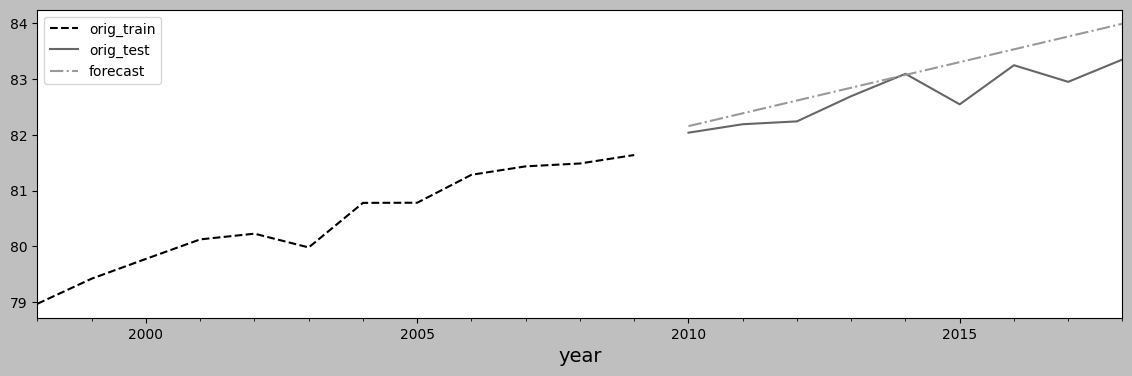

In [180]:
plot_forecast(best_m, '1998', life_train, life_test);

In [184]:
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  -0.850
Date:                Fri, 10 Jan 2025   AIC                              7.699
Time:                        20:46:14   BIC                             13.313
Sample:                    01-01-1960   HQIC                             9.820
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9441      3.508     -0.554      0.579      -8.819       4.931
ma.L2          0.9963      3.589      0.278      0.781      -6.038       8.030
sigma2         0.0501      0.182      0.276      0.783      -0.306       0.406
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.58   Prob(JB):                         0.40
Heteroskedasticity (H):               0.38   Skew:                             0.17
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

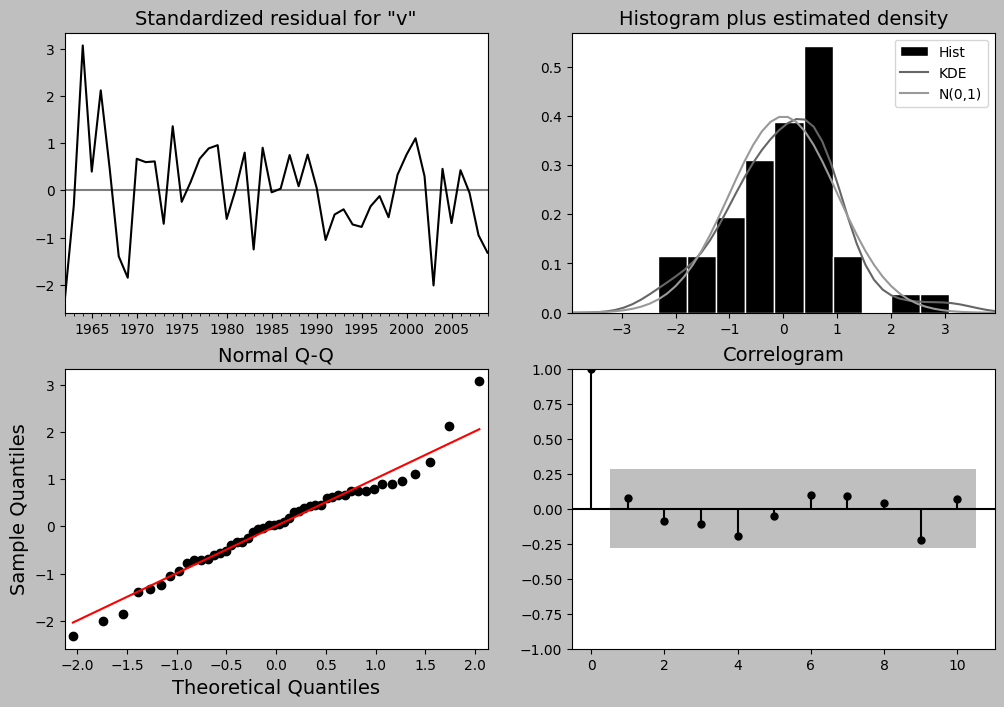

In [273]:
best_m.plot_diagnostics(figsize=(12,8));

In [285]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(milk_train, order=(p,d,q))
    res = m.fit()
    y = milk_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ch10/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information 

In [293]:
milk_top_models = get_top_models_df(score, 'AIC')
milk_top_models

,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,
26,"(2, 2, 2)",1445.411301,1460.155101,1445.855746,1.130915,103.393242,0.097152,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
23,"(2, 1, 2)",1458.932327,1473.711462,1459.373503,1.052131,96.733984,0.086554,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,"(0, 1, 2)",1466.122925,1474.990406,1466.296838,1.271762,115.822624,0.112387,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
14,"(1, 1, 2)",1466.878216,1478.701525,1467.170187,1.234587,112.601237,0.108002,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
11,"(1, 0, 2)",1467.165995,1481.980218,1467.603951,1.457496,131.857306,0.133059,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [295]:
milk_best_model = milk_top_models.iloc[0,-1]

milk_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             production   No. Observations:                  143
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -717.706
Date:                Fri, 10 Jan 2025   AIC                           1445.411
Time:                        20:56:27   BIC                           1460.155
Sample:                    01-01-1962   HQIC                          1451.403
                         - 11-01-1973                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7321      0.004   -400.818      0.000      -1.741      -1.724
ar.L2         -0.9995      0.002   -448.191      0.000      -1.004      -0.995
ma.L1          1.7117      1.628      1.052      0.293      -1.478       4.902
ma.L2          0.9992      1.894      0.527      0.598      -2.713       4.712
sigma2      1446.0637   2669.163      0.542      0.588   -3785.400    6677.528
===================================================================================
Ljung-Box (L1) (Q):                   3.55   Jarque-Bera (JB):                10.57
Prob(Q):                              0.06   Prob(JB):                         0.01
Heteroskedasticity (H):               1.27   Skew:                             0.67
Prob(H) (two-sided):                  0.42   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

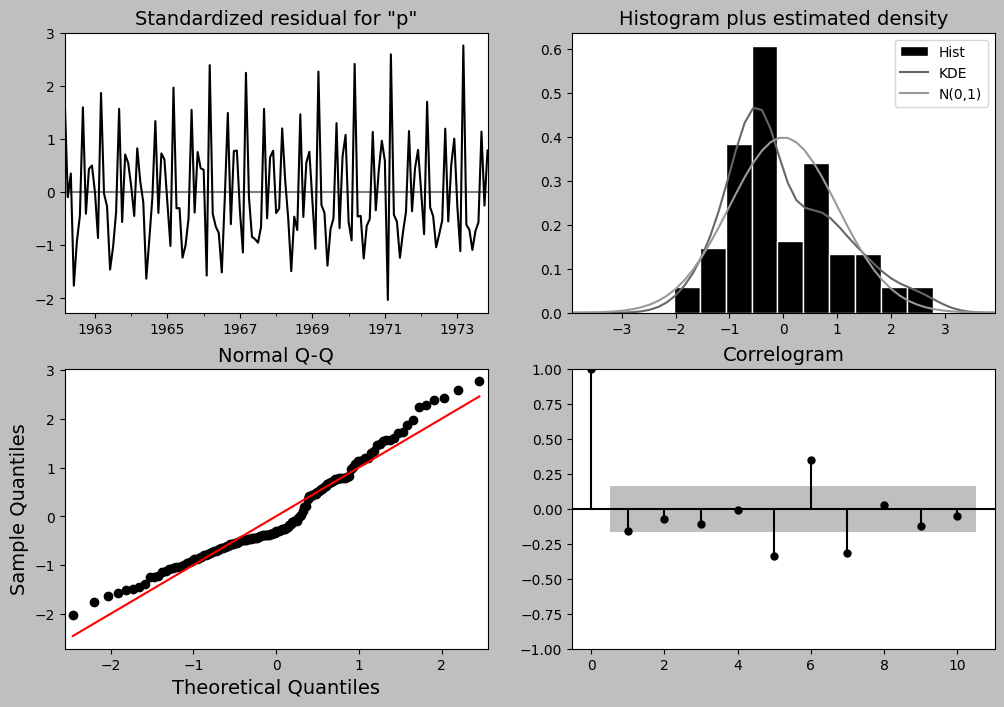

In [305]:
milk_best_model.plot_diagnostics(figsize=(12,8));

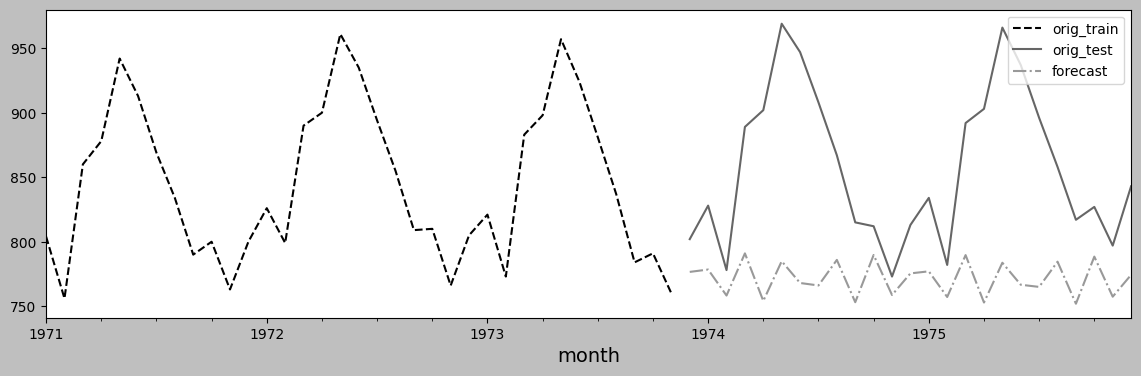

In [307]:
plot_forecast(milk_best_model, '1971', milk_train, milk_test);

# Recipe 4. Forecasting Univariate Time Series Data with Seasonal ARIMA

In [192]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.rcParams["figure.figsize"] = [14, 4]  

<Axes: xlabel='month'>

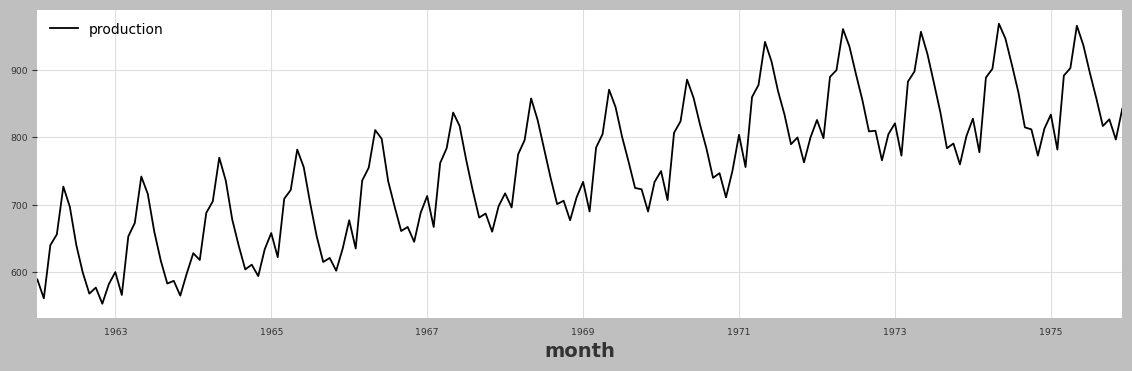

In [194]:
milk.plot()

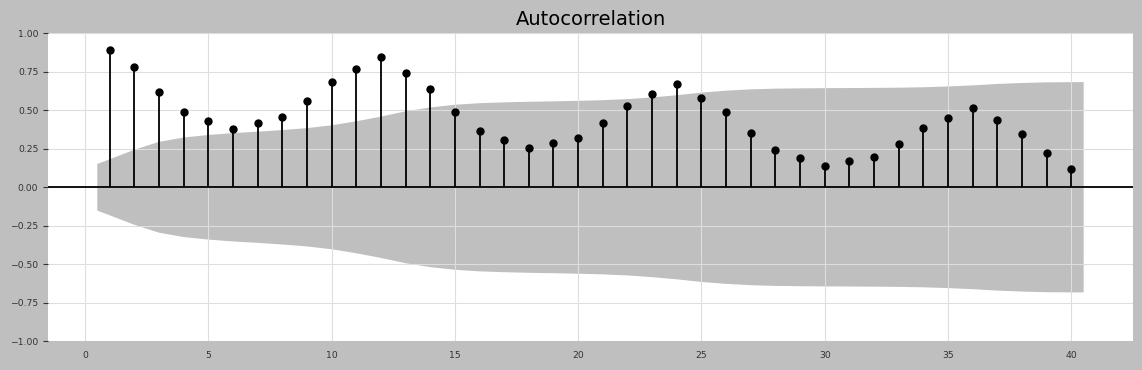

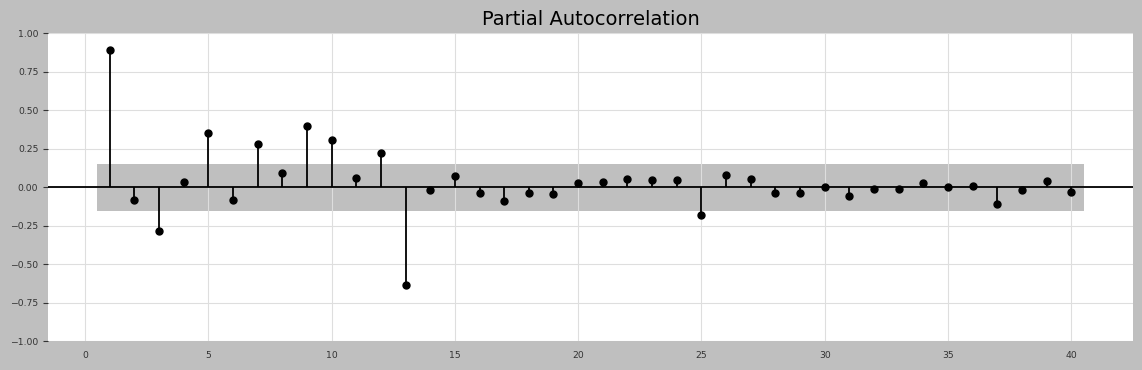

In [196]:
plot_acf(milk, lags=40, zero=False)
plot_pacf(milk, lags=40, zero=False);plt.show()

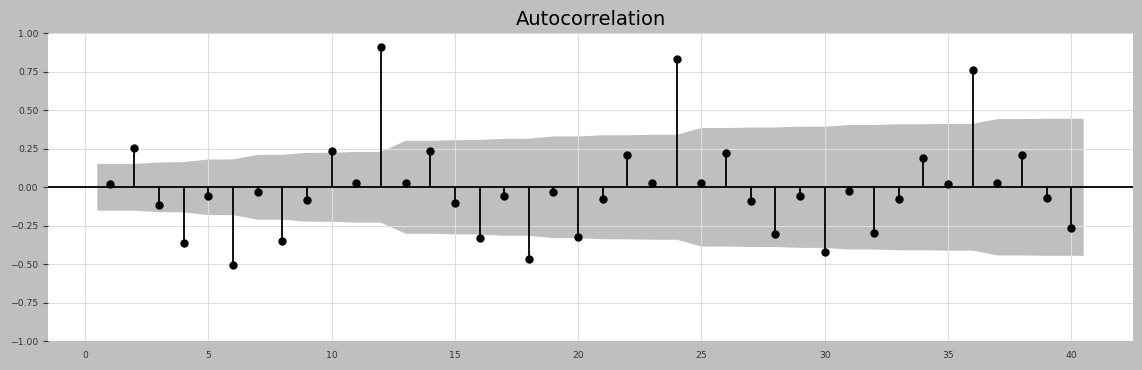

In [198]:
plot_acf(milk.diff(1).dropna(), lags=40, zero=False); 

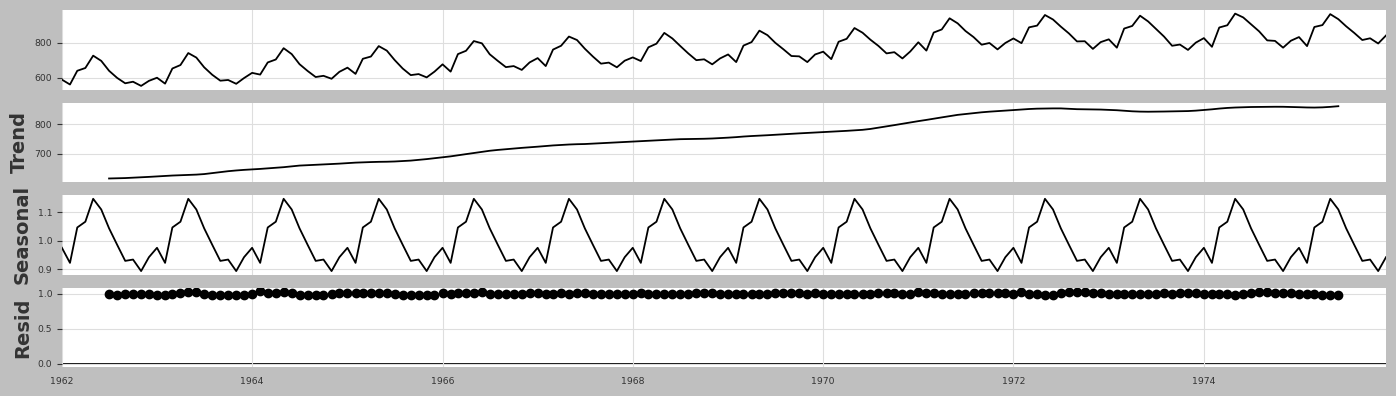

In [200]:
decomposed = seasonal_decompose(milk, period=12, model='multiplicative')
decomposed.plot(); 

In [202]:
milk_s = decomposed.seasonal

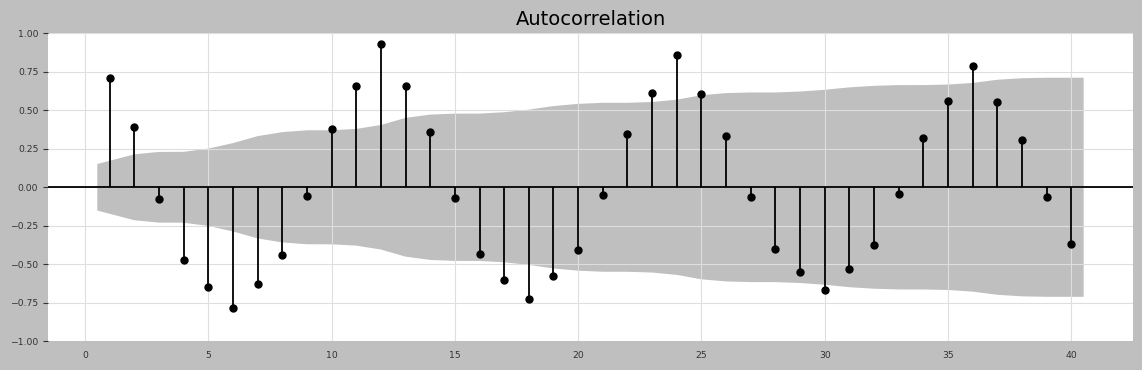

In [204]:
plot_acf(milk_s, zero=False, lags=40);plt.show()

In [206]:
milk_dif_12 = milk.diff(12).dropna()
milk_dif_12_1 = milk.diff(12).diff(1).dropna()

'Non-Stationary	 p-value:0.627426708603029 	 lags:13
'Non-Stationary	 p-value:0.16079880527711332 	 lags:12
'Stationary	 p-value:1.865423431878889e-05 	 lags:11


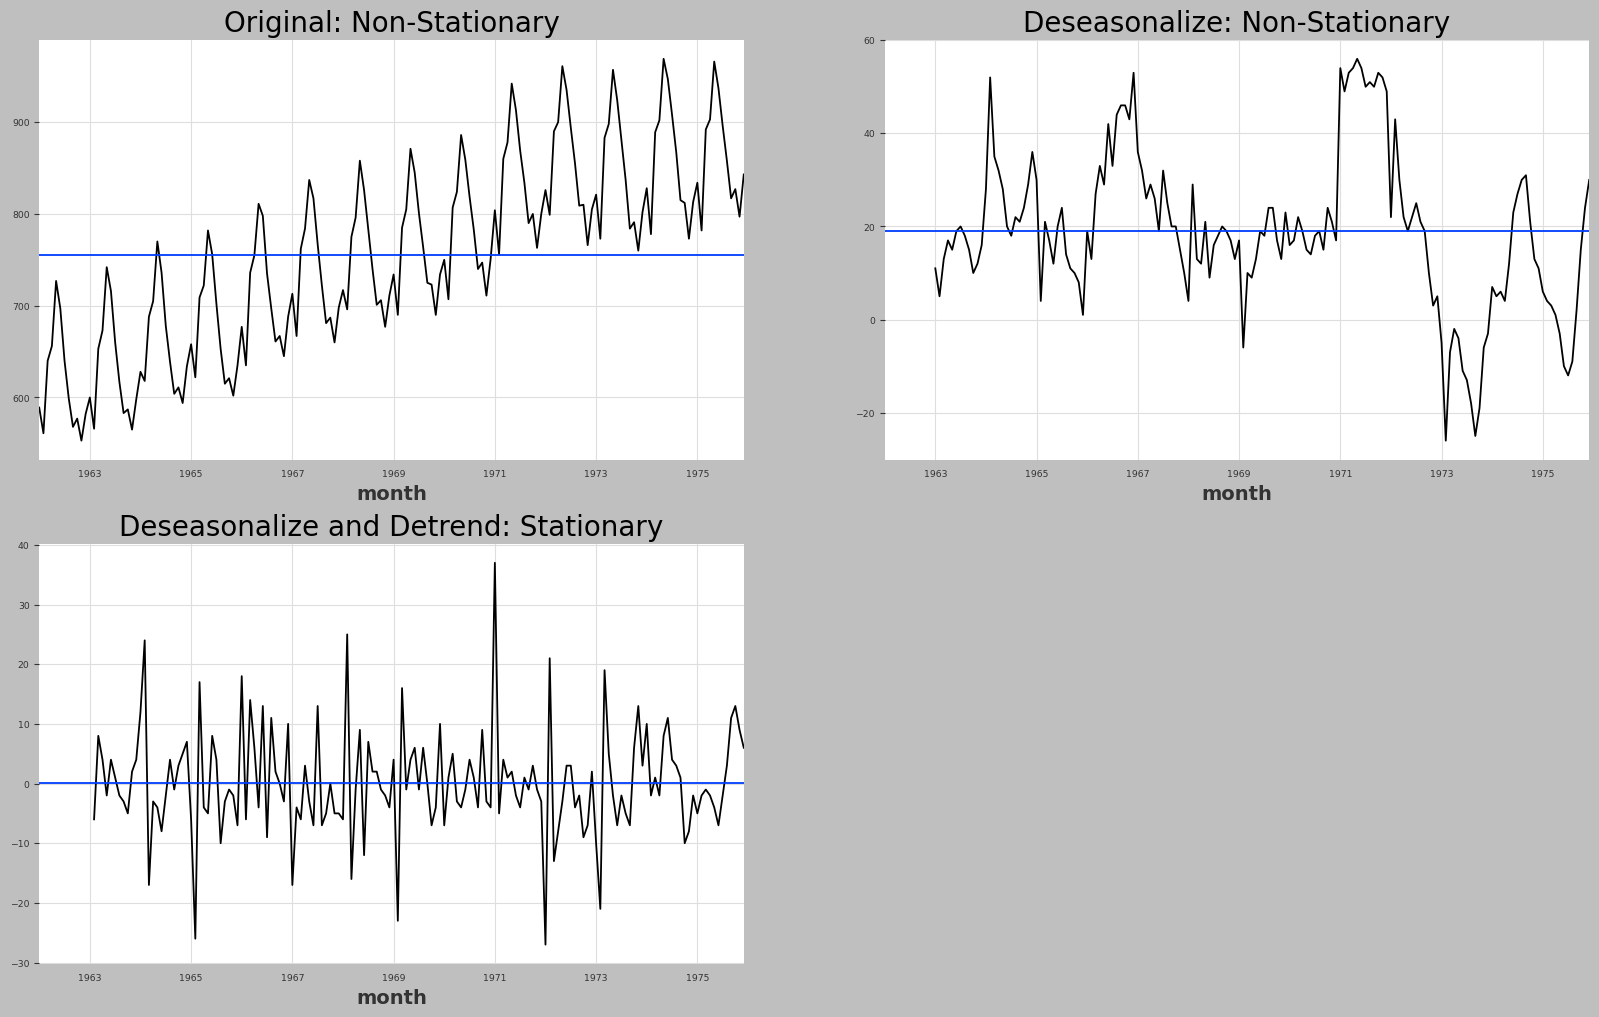

In [208]:
sets = [milk, milk_dif_12, milk_dif_12_1]
desc = ['Original', 'Deseasonalize', 'Deseasonalize and Detrend']
fig, ax = plt.subplots(2,2, figsize=(20,12))
index, l = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    v, r = i // 2, i % 2
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax= ax[v,r], title=f'{d_desc}: {outcome}', legend=False)
    pd.Series(d_set.mean().values.tolist()*l, index=index).plot(ax=ax[v,r])
    ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
# plt.savefig('images/fig_10.21.png', bbox_inches='tight', dpi=300)
plt.show()

### How to Determine AR and MA terms

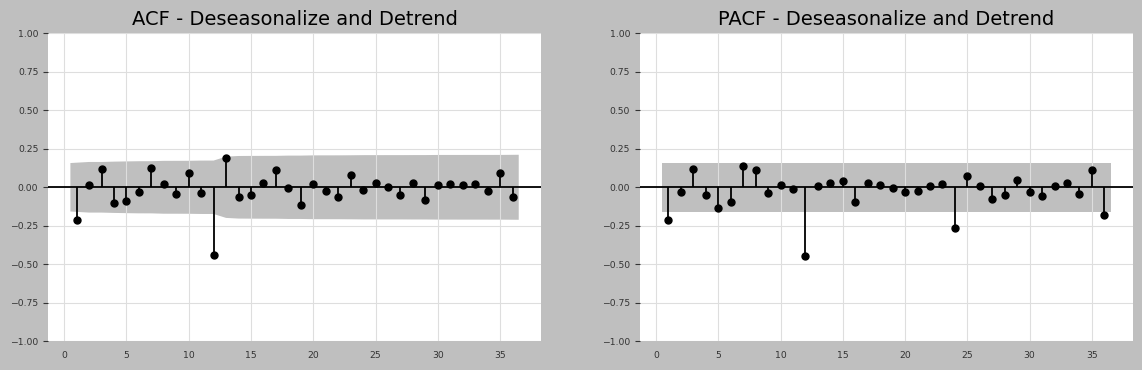

In [211]:
fig, ax = plt.subplots(1,2)
plot_acf(milk_dif_12_1, zero=False, lags=36, ax=ax[0], title=f'ACF - {d_desc}')
plot_pacf(milk_dif_12_1, zero=False, lags=36, ax=ax[1], title=f'PACF - {d_desc}')
plt.show()

[1, 12, 24, 36, 48]


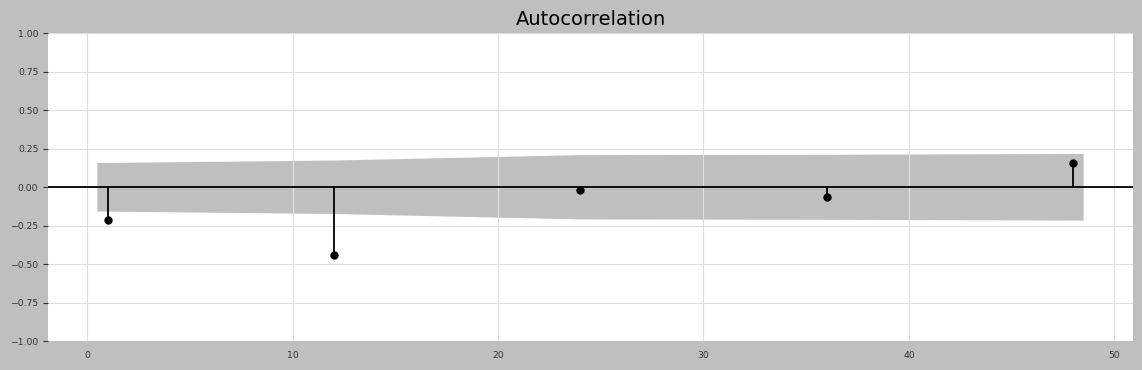

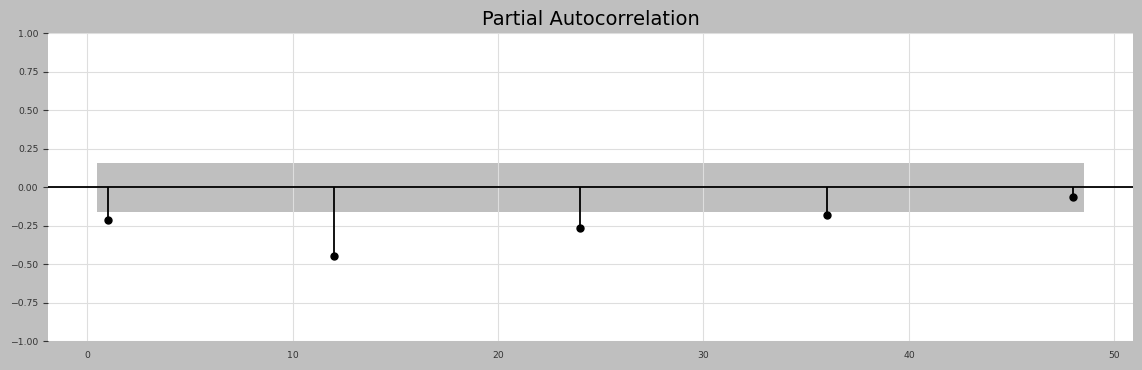

In [213]:
#lags = [1, 12, 24, 36, 48]
lags = [i for i in range(12, 60, 12)]
lags.insert(0, 1)
print(lags)
plot_acf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags)
plot_pacf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags);

### Fitting a SARIMA Model

In [216]:
sarima_model = SARIMAX(milk_train, 
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

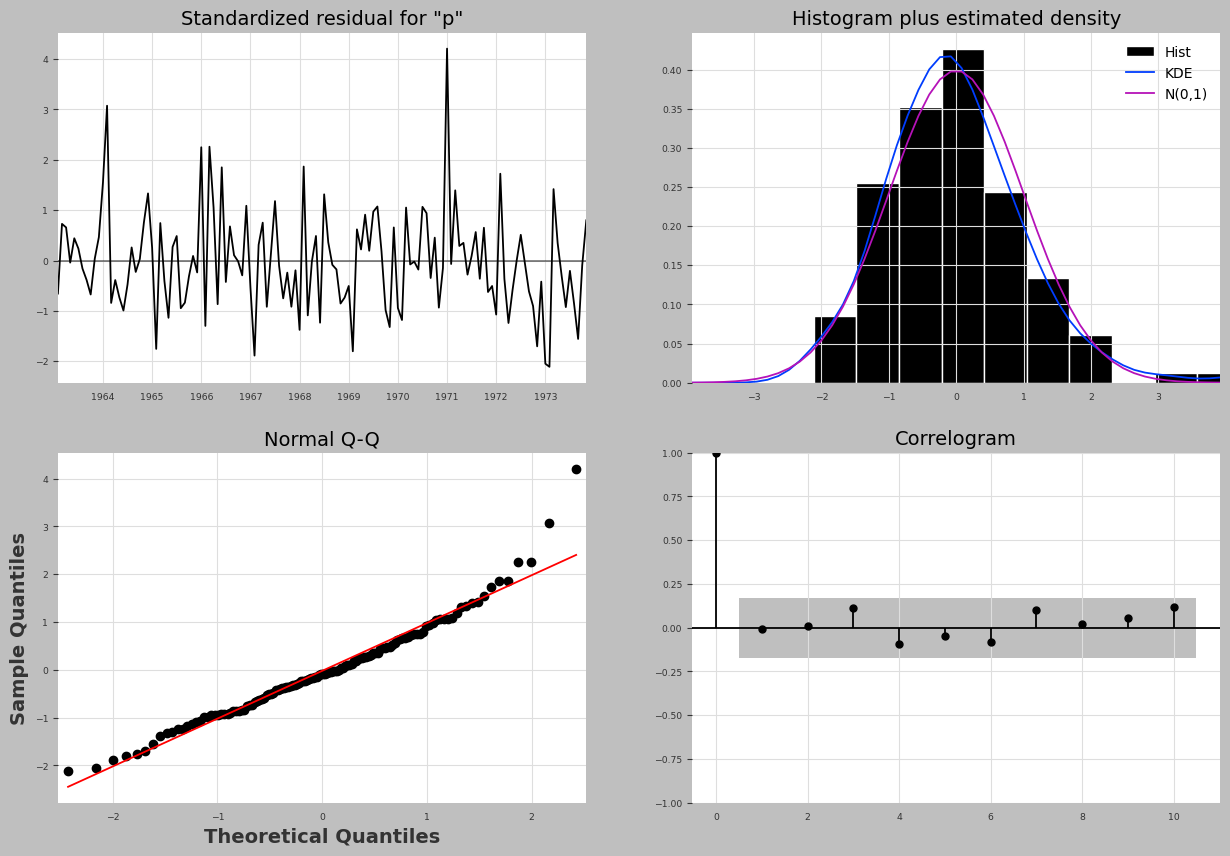

In [218]:
model.plot_diagnostics(figsize=(15,10));
# plt.savefig('images/fig_10.23.png', bbox_inches='tight', dpi=300)

In [219]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         production   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Mon, 30 Dec 2024   AIC                            903.335
Time:                                    22:58:14   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

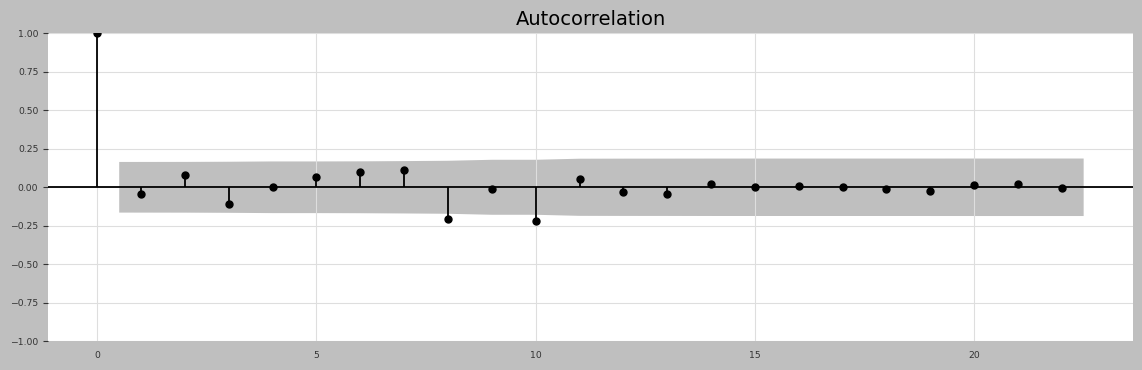

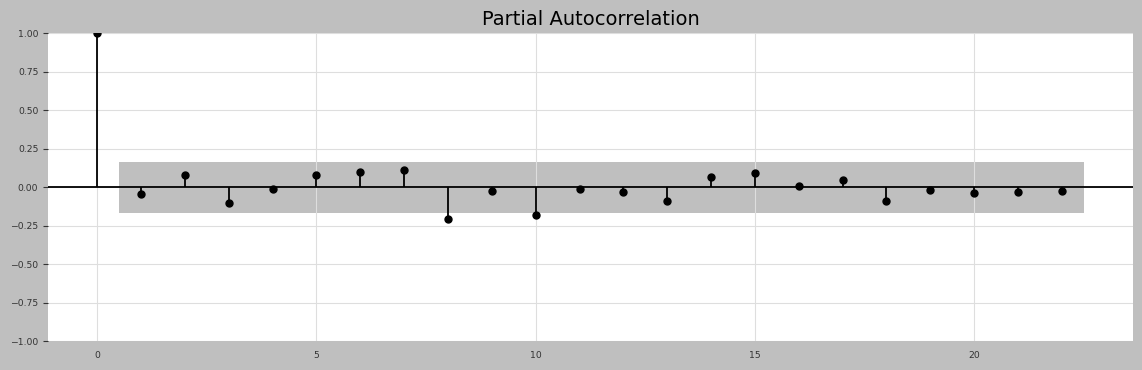

In [222]:
plot_acf(model.resid[1:]);
plot_pacf(model.resid[1:]); 

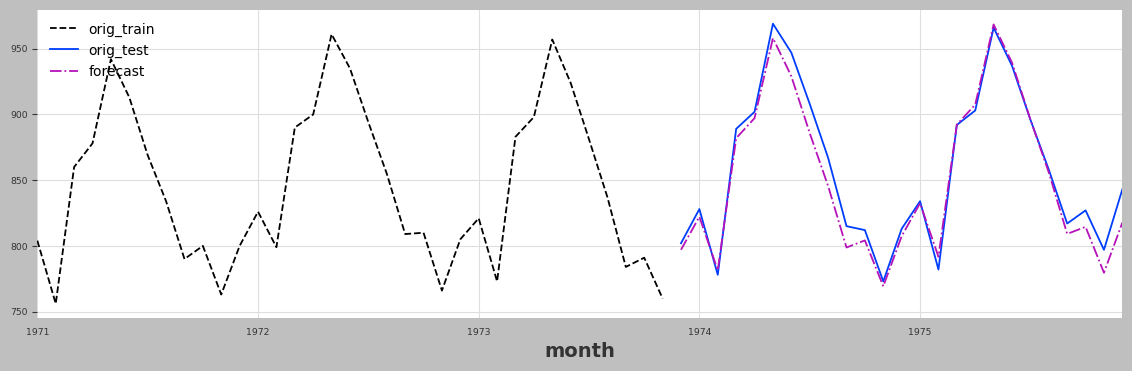

In [223]:
plot_forecast(model, '1971', milk_train, milk_test);
# plt.savefig('images/fig_10.24.png', bbox_inches='tight', dpi=300)

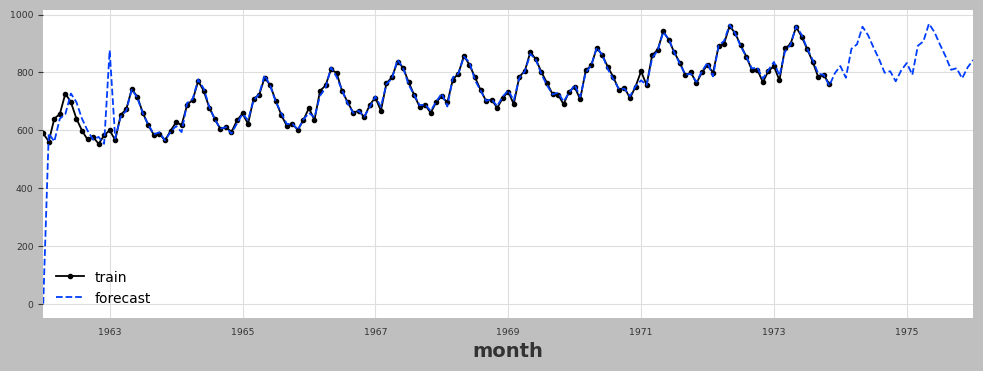

In [226]:
n = milk.shape[0]
milk_train.plot(style='.-', figsize=(12,4))
model.predict(end=n).plot(style='--')
plt.legend(['train', 'forecast'])

## There is more

In [229]:
%%time
P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(2))]*3

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')
    m = SARIMAX(milk_train, 
                order=(p,d,q),
                seasonal_order=(P, D, Q, 12),
                enforce_stationarity=False)
    res = m.fit(disp=0)
    y = milk_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic, 
                'AICc': res.aicc,
                'BIC': res.bic,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

Running model #0 using SARIMA(0,0,0)(0,0,0,12)
Running model #15 using SARIMA(0,0,1)(1,1,1,12)
Running model #30 using SARIMA(0,1,0)(1,1,0,12)
Running model #45 using SARIMA(0,1,2)(1,0,1,12)
Running model #60 using SARIMA(0,2,1)(1,0,0,12)
Running model #75 using SARIMA(1,0,0)(0,1,1,12)
Running model #90 using SARIMA(1,0,2)(0,1,0,12)
Running model #105 using SARIMA(1,1,1)(0,0,1,12)
Running model #120 using SARIMA(1,2,0)(0,0,0,12)
Running model #135 using SARIMA(1,2,1)(1,1,1,12)
Running model #150 using SARIMA(2,0,0)(1,1,0,12)
Running model #165 using SARIMA(2,0,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,1)(1,0,0,12)
Running model #195 using SARIMA(2,2,0)(0,1,1,12)
Running model #210 using SARIMA(2,2,2)(0,1,0,12)
CPU times: user 23.1 s, sys: 238 ms, total: 23.4 s
Wall time: 23.5 s


In [230]:
3*3*3*2*2*2

216

In [231]:
get_top_models_df(score, 'AIC')

,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,,
211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.178190,15.135857,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
67,"(0, 2, 2)","(0, 1, 1)",795.515920,795.882892,806.460713,0.328243,27.797479,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487077,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
191,"(2, 1, 2)","(1, 1, 1)",796.784231,797.830960,815.998756,0.112001,9.637001,0.009074,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.128260,10.998609,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [232]:
get_top_models_df(score, 'BIC')

,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,,
67,"(0, 2, 2)","(0, 1, 1)",795.515920,795.882892,806.460713,0.328243,27.797479,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487077,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
35,"(0, 1, 1)","(0, 1, 1)",802.462674,802.676959,810.723444,0.134090,11.489677,0.010370,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.798080,0.289726,24.535336,0.024770,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.178190,15.135857,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [233]:
best_model = get_top_models_df(score, 'BIC').iloc[0,-1]
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           production   No. Observations:                  143
Model:             SARIMAX(0, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -393.758
Date:                              Mon, 30 Dec 2024   AIC                            795.516
Time:                                      22:58:39   BIC                            806.461
Sample:                                  01-01-1962   HQIC                           799.958
                                       - 11-01-1973                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2806      0.096    -13.353      0.000      -1.469      -1.093
ma.L2          0.3054      0.107      2.860      0.004       0.096       0.515
ma.S.L12      -0.6217      0.082     -7.556      0.000      -0.783      -0.460
sigma2        56.9487      6.214      9.165      0.000      44.769      69.128
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                28.17
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             0.76
Prob(H) (two-sided):                  0.42   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

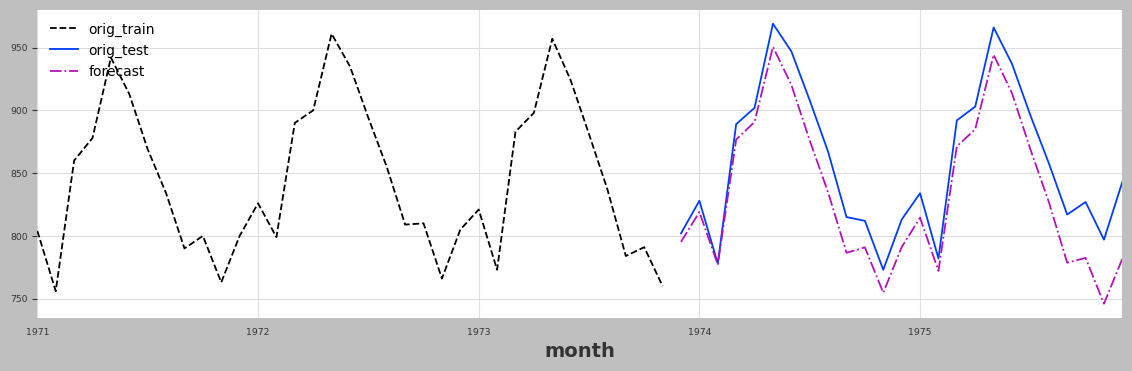

In [234]:
plot_forecast(best_model, '1971', milk_train, milk_test);
# plt.savefig('images/fig_10.25.png', bbox_inches='tight', dpi=300)

# Recipe 5: Forecasting Time Series Data using Auto_ARIMA

You will need to install pmdarima before you can proceed with this recipe. 

* To install it using `pip`, use the following command:

```
pip install pmdarima
```

* To install it using `conda`, use the following command:
```
conda install -c conda-forge pmdarima

In [236]:
import pmdarima as pm

In [237]:
pm.__version__

'2.0.4'

In [238]:
milk_train.shape

(143, 1)

In [239]:
milk_test.shape

(25, 1)

In [250]:
milk_train.head()

,production
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [252]:
auto_model = pm.auto_arima(milk_train, 
                           seasonal=True, 
                           m=12, 
                           test='adf',
                           stepwise=True)

In [253]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Mon, 30 Dec 2024   AIC                            903.335
Time:                                    22:59:31   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [254]:
auto_model = pm.auto_arima(milk_train, 
                           seasonal=True, 
                           m=12, 
                           test='adf', 
                           stepwise=True,
                           trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=908.834, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=951.320, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=917.481, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=903.335, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=940.547, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=905.280, Time=0.08 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=905.265, Time=0.21 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=917.295, Time=0.06 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=911.816, Time=0.03 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=905.240, Time=0.09 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=905.159, Time=0.09 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=903.959, Time=0.06 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=907.070, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   

In [255]:
auto_model = pm.auto_arima(milk_train, 
                           seasonal=True, 
                           m=12, 
                           test='adf', 
                           information_criterion='bic',
                           stepwise=True,
                           trace=True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,1,1)[12]             : BIC=928.907, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=954.187, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=926.083, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=911.938, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=946.282, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : BIC=916.750, Time=0.08 sec
 ARIMA(0,1,1)(0,1,2)[12]             : BIC=916.735, Time=0.22 sec
 ARIMA(0,1,1)(1,1,0)[12]             : BIC=925.897, Time=0.04 sec
 ARIMA(0,1,1)(1,1,2)[12]             : BIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,1,1)[12]             : BIC=917.551, Time=0.04 sec
 ARIMA(1,1,1)(0,1,1)[12]             : BIC=916.710, Time=0.08 sec
 ARIMA(0,1,2)(0,1,1)[12]             : BIC=916.630, Time=0.08 sec
 ARIMA(1,1,0)(0,1,1)[12]             : BIC=912.562, Time=0.06 sec
 ARIMA(1,1,2)(0,1,1)[12]             : BIC=921.407, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   

In [256]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Mon, 30 Dec 2024   AIC                            903.335
Time:                                    22:59:36   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

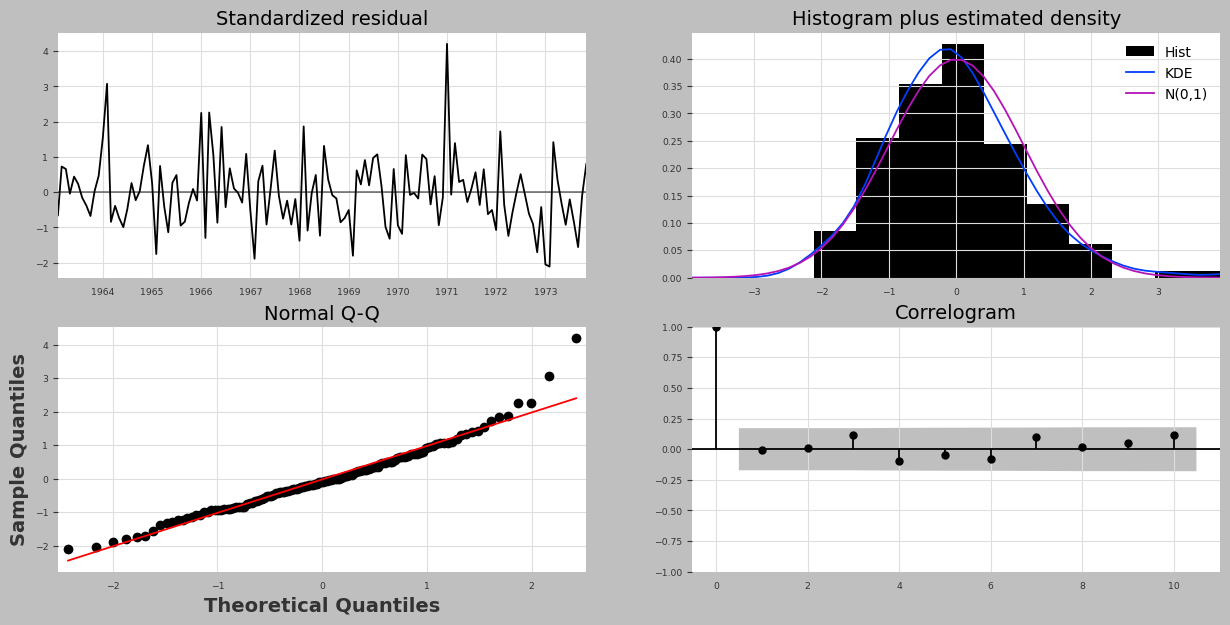

In [257]:
auto_model.plot_diagnostics(figsize=(15,7));

In [258]:
auto_model.scoring

'mse'

In [259]:
auto_model

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

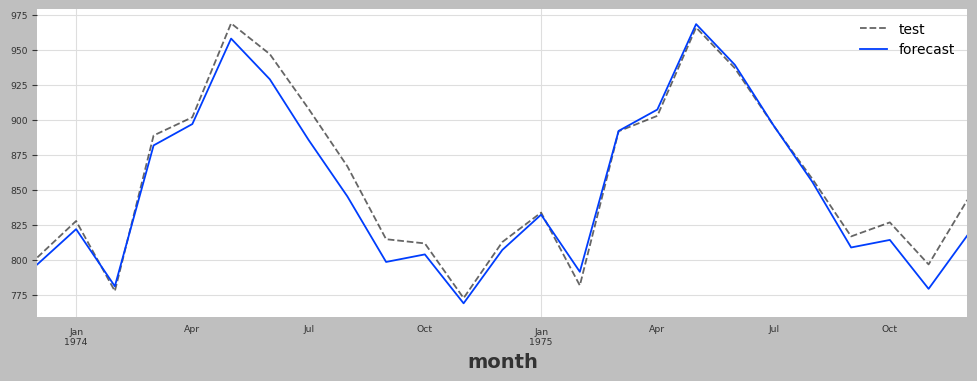

In [262]:
n = milk_test.shape[0]
index = milk_test.index
ax = milk_test.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(auto_model.predict(n_periods=n), 
          index=index).plot(style='-', ax=ax)
plt.legend(['test', 'forecast']); plt.show()

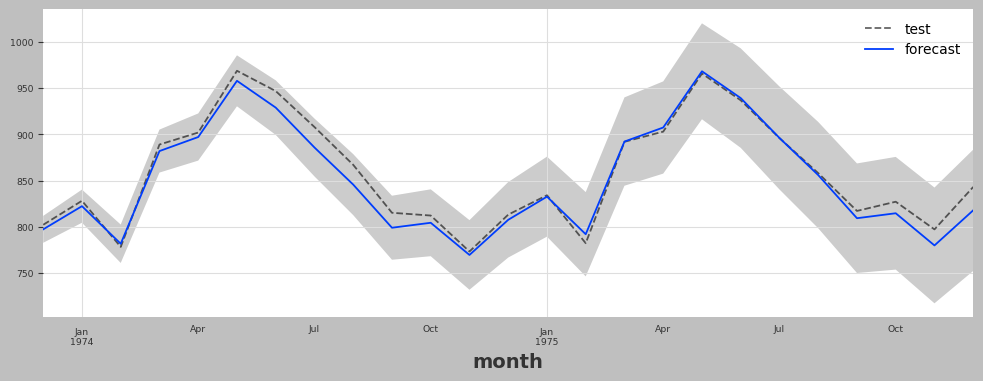

In [263]:
n = milk_test.shape[0]
forecast, conf_interval = auto_model.predict(n_periods=n, 
                                             return_conf_int=True,
                                            alpha=0.05)
lower_ci, upper_ci  = zip(*conf_interval)

index = milk_test.index
ax = milk_test.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(forecast, index=index).plot(style='-', ax=ax)
plt.fill_between(index, lower_ci, upper_ci, alpha=0.2)
plt.legend(['test', 'forecast']);

## There is more

In [265]:
from pmdarima.arima.utils import ndiffs, nsdiffs

# ADF test:
n_adf = ndiffs(milk, test='adf') 
# KPSS test (auto_arima default):
n_kpss = ndiffs(milk, test='kpss') 
# PP test:
n_pp = ndiffs(milk, test='pp')  

In [267]:
print(f'''
differencing (d) term using:
    ADF: {n_adf}
    KPSS: {n_kpss}
    PP: {n_pp}
''')


differencing (d) term using:
    ADF: 0
    KPSS: 1
    PP: 0



In [277]:
# OCSB test
max_D = nsdiffs(milk, test='ocsb', m=12, max_D=12) 

In [279]:
print(f'''
Seasonal differencing (D) term: {max_D}
''')


Seasonal differencing (D) term: 1



In [281]:
model = pm.auto_arima(milk_train, 
                      seasonal=True,
                      with_intercept=True,
                      d=1,
                      max_d=2,
                      start_p=0, max_p=2,
                      start_q=0, max_q=2,
                      m=12,
                      D=1,
                      max_D=2,
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=2,
                      information_criterion='aic',
                      stepwise=False,
                      out_of_sample_siz=25,
                      test = 'kpss',
                      score='mape',
                      trace=True)                      


 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=953.294, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=913.693, Time=0.07 sec
 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=915.576, Time=0.19 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=928.929, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=915.603, Time=0.07 sec
 ARIMA(0,1,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=921.521, Time=0.15 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=916.806, Time=0.24 sec
 ARIMA(0,1,0)(2,1,2)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=942.458, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=905.043, Time=0.07 sec
 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=906.971, Time=0.23 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=919.027, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=906.985, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[12] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,1,1)(2,1,0)[1

In [282]:
model.out_of_sample_size

0

In [283]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -446.284
Date:                            Mon, 30 Dec 2024   AIC                            904.567
Time:                                    22:59:57   BIC                            921.773
Sample:                                01-01-1962   HQIC                           911.558
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2781      0.655     -0.424      0.671      -1.563       1.006
ar.L1         -1.2086      0.091    -13.352      0.000      -1.386      -1.031
ar.L2         -0.3154      0.103     -3.072      0.002      -0.517      -0.114
ma.L1          0.9691      0.054     17.793      0.000       0.862       1.076
ma.S.L12      -0.6235      0.087     -7.142      0.000      -0.795      -0.452
sigma2        52.9649      5.742      9.225      0.000      41.711      64.218
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                49.33
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.92
Prob(H) (two-sided):                  0.58   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

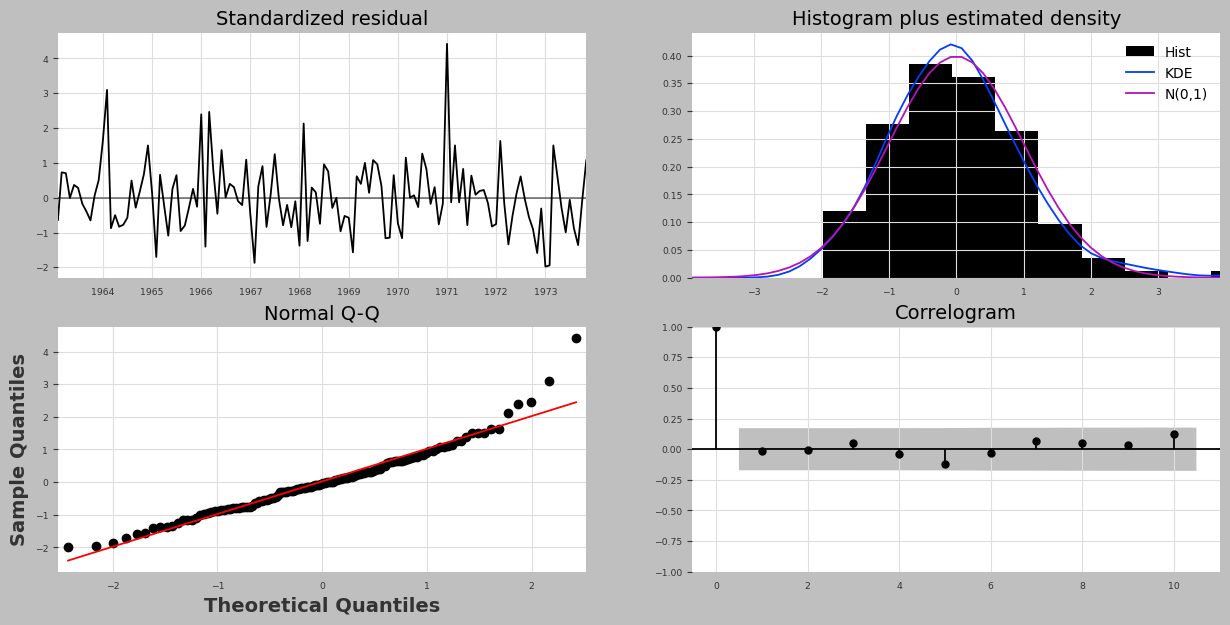

In [284]:
model.plot_diagnostics(figsize=(15,7));

In [285]:
# !pip install "u8darts[all]"

In [286]:
from darts.models import AutoARIMA
from darts import TimeSeries

### Using Darts AutoARIMA

In [288]:
model = AutoARIMA(seasonal=True, 
                           m=12,
                 stepwise=True)

In [289]:
ts = TimeSeries.from_dataframe(milk_train.reset_index(), 
                                    time_col='month', value_cols='production', freq='MS')

In [290]:
darts_arima = model.fit(ts)

In [291]:
darts_arima.model.model_.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 0, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 1, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [292]:
darts_arima.model.model_

ARIMA(order=(3, 0, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True)

In [293]:
darts_forecast = model.predict(len(milk_test))
darts_forecast.values()

array([[800.31981108],
       [826.62717639],
       [788.49562611],
       [889.73649858],
       [907.2312882 ],
       [968.90456536],
       [941.69375178],
       [899.14897119],
       [860.40263205],
       [814.30413263],
       [820.92605578],
       [786.66911035],
       [826.99836486],
       [853.13951083],
       [814.1944671 ],
       [915.50893926],
       [932.28146914],
       [993.98159328],
       [966.19788487],
       [923.62842549],
       [884.43094459],
       [838.27476519],
       [844.53895904],
       [810.20620601],
       [850.24931084]])

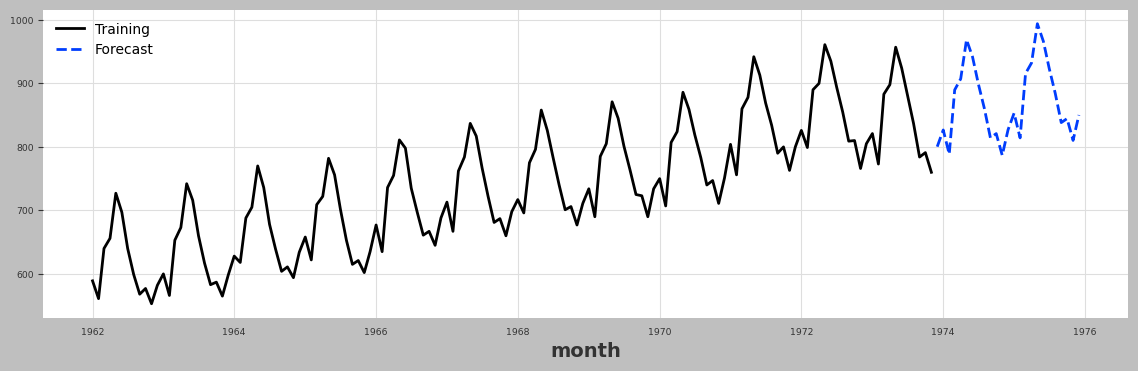

In [294]:
ts.plot(label='Training')
darts_forecast.plot(label='Forecast', linestyle='--');

### Using Darts StatsForecastAutoARIMA

In [296]:
from darts.models import StatsForecastAutoARIMA

In [297]:
model = StatsForecastAutoARIMA(season_length=12)
model.fit(ts)
pred = model.predict(len(milk_test))

In [298]:
model.model.model_.get('arma')

(1, 1, 0, 1, 12, 0, 1)

In [299]:
pred.values()

array([[800.28453919],
       [827.4772704 ],
       [788.64452067],
       [890.87039517],
       [907.74954615],
       [970.22681412],
       [942.58619764],
       [900.60338338],
       [861.55757857],
       [815.92439141],
       [822.33514468],
       [788.40552424],
       [828.57521783],
       [855.27706743],
       [815.98985623],
       [917.79498728],
       [934.28461115],
       [996.40125232],
       [968.42676514],
       [926.13485116],
       [886.80287975],
       [840.90475765],
       [847.07023238],
       [812.91353143],
       [852.87299236]])

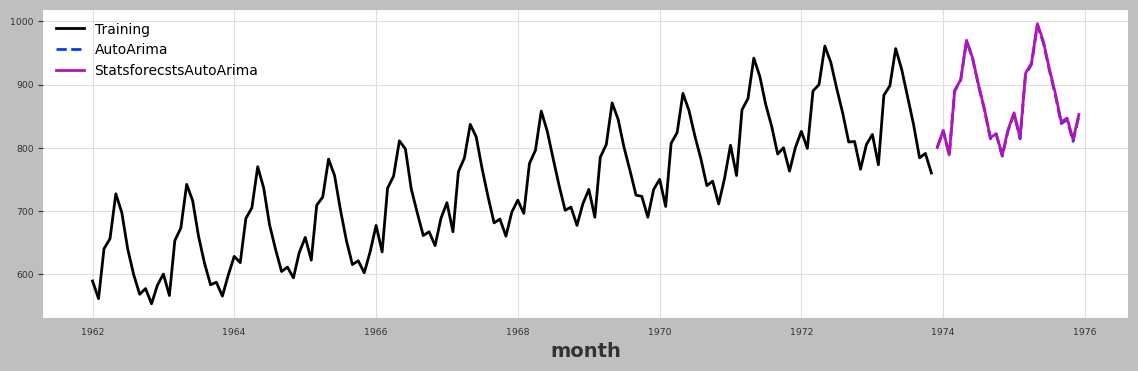

In [300]:
ts.plot(label='Training')
darts_forecast.plot(label='AutoArima', linestyle='--');
pred.plot(label='StatsforecstsAutoArima');